**Анализ целевой аудитории сервиса аренды пауэрбанков**

**Задача**

Сформировать портрет ЦА и предложить гипотезы по масштабированию бизнеса.



**План работы**

1. Пауэрбанки.

  1.1. Предобработка датасетов.

  1.2. Зарядные статусы пауэрбанков.

  1.3. Заблокированные пауэрбанки.

2. Станции

  2.1. Предобработка датасета.

  2.2. Заблокированные станции.

  2.3. Количество слотов в станциях.

  2.4. Заведения, где размещены станции.

3. Аренда пауэрбанков.

  3.1. Предобработка датасета.

  3.2. Подготовка к анализу.

  3.3. Проверка активности станций.
  
  3.4. Анализ типов заведений, установивших станции.

4. Доходы.

  4.1. Доходы франчайзи на территории России.

    4.1.1. Анализ станций по окупаемости.
      - Активные и отключенные станции.
      - Количество слотов у станции.

  4.2. Доходы компании на территории России.
  
  4.3. Доходы франчайзи на территории Беларуси.
    
    4.3.1. Анализ станций по окупаемости.
      - Активные и отключенные станции.
      - Количество слотов у станции.
  
  4.4. Доходы компании на территории Беларуси.

5. Выводы.

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import json

from pandas.io.json import json_normalize
from scipy import stats

import warnings

In [13]:
# скорректируем отображение float
pd.options.display.float_format = '{:.0f}'.format

warnings.filterwarnings('ignore')

In [14]:
# разноформатные таблицы, ниже проверим их соответствие

path_prefix = '/content/drive/MyDrive/Colab Notebooks/ChargeX/'
# path_prefix = './'

pb_csv = pd.read_csv(path_prefix+'power_banks.csv')
pb_json = pd.read_json(path_prefix+'power_banks.json')

rents = pd.read_csv(path_prefix+'rents.csv')
stations = pd.read_csv(path_prefix+'stations.csv')
transactions = pd.read_csv(path_prefix+'transactions.csv')
group_tariffs = pd.read_csv(path_prefix+'group_tariffs.csv')

**1. Пауэрбанки**

Датасеты содержат информацию об имеющихся пауэрбанках. По имеющейся информации файл формата .json более актуальный.

Не все значения датасета были определены точно, но внимание было сфокусировано только на необходимых по текущему заданию.



`atUser` — находится в аренде (?);

`_id` — ID записи в датасете;

`powerBankId` — ID пауэрбанка;

`created` — дата занесения в базу (?);

`slot` — номер слота, в котором размещен пауэрбанк в станции;

`status` — статус;

`statusAt` — дата появления статуса;

`battaryLevelPercent` — уровень зарядки пауэрбанка;

`battaryLevel` — категория по уровню зарядки;

`lastStation` — последняя станция (читается только в формате .json);

`blocked` — заблокирован ли пауэрбанк;

`owner` — владелец (станции? пауэрбанка?).



Ознакомимся с датасетами.

**1.1. Предобработка датасетов**

In [16]:
# сначала посмотрим на файл .csv
print(pb_csv.shape)
display(pb_csv.head(3))
print('\033[1m' + 'Информация о датафрейме' + '\033[0m')
print(pb_csv.info())
print()
print('\033[1m' + 'Количество пропусков' + '\033[0m')
print(pb_csv.isnull().sum())
print()
print('\033[1m' + 'Количество дубликатов' + '\033[0m')
print(pb_csv.duplicated().sum())

(8738, 13)


,_class,_id,atUser,batteryLevel,batteryLevelPercent,blocked,created,lastStation,owner,powerBankId,slot,status,statusAt
0,com.zaryad.zaryad.backend.common.model.station...,5f2ea70ebe0777000773cd5b,NaN,PERCENT_UNKNOWN,-1,NaN,2020-08-08T13:22:22.512Z,[object Object],NaN,6143549019743347460,5,RENTED,2020-10-27T11:25:30.908Z
1,com.zaryad.zaryad.backend.common.model.station...,5f2ea70ebe0777000773cd5c,admin,PERCENT_UNKNOWN,-1,False,2020-08-08T13:22:22.535Z,[object Object],60a670d760f61b6f012586d3,5930171193772474470,4,RENTED,2022-11-09T17:38:07.582Z
2,com.zaryad.zaryad.backend.common.model.station...,5f2ea70ebe0777000773cd5d,NaN,PERCENT_81_100,100,NaN,2020-08-08T13:22:22.537Z,[object Object],NaN,5930171193772475241,6,LOST,2022-01-27T14:36:49.980Z


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8738 entries, 0 to 8737
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   _class               8738 non-null   object
 1   _id                  8738 non-null   object
 2   atUser               376 non-null    object
 3   batteryLevel         8738 non-null   object
 4   batteryLevelPercent  8738 non-null   int64 
 5   blocked              6146 non-null   object
 6   created              8738 non-null   object
 7   lastStation          8738 non-null   object
 8   owner                6143 non-null   object
 9   powerBankId          8738 non-null   int64 
 10  slot                 8738 non-null   int64 
 11  status               8738 non-null   object
 12  statusAt             8738 non-null   object
dtypes: int64(3), object(10)
memory usage: 887.6+ KB
None

Количество пропусков
_class                    0
_id                       

В датасете 8738 уникальных записей, имеются пропуски в данных: не для всех пауэрбанков известно, находятся ли они в аренде, заблокированы ли и кто владелец.

Также не все типы данных верны. Исправим.

In [17]:
pb_csv['created'] = pd.to_datetime(pb_csv['created'])
pb_csv['statusAt'] = pd.to_datetime(pb_csv['statusAt'])

Обратимся к файлу в формате .json.

In [18]:
print(pb_json.shape)
display(pb_json.head(3))

(9174, 13)


,_id,powerBankId,created,slot,status,statusAt,batteryLevelPercent,batteryLevel,lastStation,_class,blocked,atUser,owner
0,{'$oid': '5f2ea70ebe0777000773cd5b'},6143549020000000000,{'$date': {'$numberLong': '1596892942512'}},5,RENTED,{'$date': {'$numberLong': '1603797930908'}},-1,PERCENT_UNKNOWN,"{'$ref': 'station', '$id': {'$oid': '5f8d4d34a...",com.zaryad.zaryad.backend.common.model.station...,NaN,None,None
1,{'$oid': '5f2ea70ebe0777000773cd5c'},5930171194000000000,{'$date': {'$numberLong': '1596892942535'}},4,IN_STATION,{'$date': {'$numberLong': '1670944805711'}},100,PERCENT_81_100,"{'$ref': 'station', '$id': {'$oid': '60718d418...",com.zaryad.zaryad.backend.common.model.station...,0,admin,60a670d760f61b6f012586d3
2,{'$oid': '5f2ea70ebe0777000773cd5d'},5930171194000000000,{'$date': {'$numberLong': '1596892942537'}},6,LOST,{'$date': {'$numberLong': '1643294209980'}},100,PERCENT_81_100,"{'$ref': 'station', '$id': {'$oid': '605ca5ced...",com.zaryad.zaryad.backend.common.model.station...,NaN,None,None


Исправим данные в столбцах `_id`, `created`, `statusAt` и `lastStation`.

In [19]:
pb_json['_id'] = pd.json_normalize(pb_json['_id'])
pb_json['created'] = pd.json_normalize(pb_json['created'])['$date.$numberLong']
pb_json['created'] = pd.to_datetime(pb_json['created'], unit='ms')
pb_json['statusAt'] = pd.json_normalize(pb_json['statusAt'])['$date.$numberLong']
pb_json['statusAt'] = pd.to_datetime(pb_json['statusAt'], unit='ms')
pb_json['lastStation'] = pd.json_normalize(pb_json['lastStation'])['$id.$oid']

print(pb_json.shape)
display(pb_json.head())
print('\033[1m' + 'Информация о датафрейме' + '\033[0m')
print(pb_json.info())
print()
print('\033[1m' + 'Количество пропусков' + '\033[0m')
print(pb_json.isnull().sum())
print()
print('\033[1m' + 'Количество дубликатов' + '\033[0m')
print(pb_json.duplicated().sum())

(9174, 13)


,_id,powerBankId,created,slot,status,statusAt,batteryLevelPercent,batteryLevel,lastStation,_class,blocked,atUser,owner
0,5f2ea70ebe0777000773cd5b,6143549020000000000,2020-08-08 13:22:22.512,5,RENTED,2020-10-27 11:25:30.908,-1,PERCENT_UNKNOWN,5f8d4d34a7b11b0006445529,com.zaryad.zaryad.backend.common.model.station...,NaN,None,None
1,5f2ea70ebe0777000773cd5c,5930171194000000000,2020-08-08 13:22:22.535,4,IN_STATION,2022-12-13 15:20:05.711,100,PERCENT_81_100,60718d418a68ae7e3277ba30,com.zaryad.zaryad.backend.common.model.station...,0,admin,60a670d760f61b6f012586d3
2,5f2ea70ebe0777000773cd5d,5930171194000000000,2020-08-08 13:22:22.537,6,LOST,2022-01-27 14:36:49.980,100,PERCENT_81_100,605ca5cedcc7b740f4ea5f0e,com.zaryad.zaryad.backend.common.model.station...,NaN,None,None
3,5f2ea70ebe0777000773cd5e,5930171194000000000,2020-08-08 13:22:22.538,5,LOST,2022-01-27 14:36:49.981,100,PERCENT_81_100,605ca5cedcc7b740f4ea5f0e,com.zaryad.zaryad.backend.common.model.station...,NaN,None,None
4,5f2ea70ebe0777000773cd5f,6143549020000000000,2020-08-08 13:22:22.539,17,RENTED,2020-10-29 16:27:51.190,-1,PERCENT_UNKNOWN,5f8d4d34a7b11b0006445529,com.zaryad.zaryad.backend.common.model.station...,NaN,None,None


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9174 entries, 0 to 9173
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   _id                  9174 non-null   object        
 1   powerBankId          9174 non-null   float64       
 2   created              9174 non-null   datetime64[ns]
 3   slot                 9174 non-null   int64         
 4   status               9174 non-null   object        
 5   statusAt             9174 non-null   datetime64[ns]
 6   batteryLevelPercent  9174 non-null   int64         
 7   batteryLevel         9174 non-null   object        
 8   lastStation          9174 non-null   object        
 9   _class               9174 non-null   object        
 10  blocked              6596 non-null   float64       
 11  atUser               2356 non-null   object        
 12  owner                6593 non-null   object        
dtypes: dateti

In [20]:
# проверим временные периоды обеих таблиц
print('\033[1m' + 'Временной период таблицы pb_csv' + '\033[0m')
print('Самая ранняя дата установки терминала:', pb_csv['created'].min())
print('Самая поздняя дата установки терминала:', pb_csv['created'].max())
print()
print('Самая ранняя дата статуса:', pb_csv['statusAt'].min())
print('Самая поздняя дата статуса:', pb_csv['statusAt'].max())
print()
print('\033[1m' + 'Временной период таблицы pb_json' + '\033[0m')
print('Самая ранняя дата установки терминала:', pb_json['created'].min())
print('Самая поздняя дата установки терминала:', pb_json['created'].max())
print()
print('Самая ранняя дата статуса:', pb_json['statusAt'].min())
print('Самая поздняя дата статуса:', pb_json['statusAt'].max())

Временной период таблицы pb_csv
Самая ранняя дата установки терминала: 2020-08-08 13:22:22.512000+00:00
Самая поздняя дата установки терминала: 2022-11-15 10:43:21.283000+00:00

Самая ранняя дата статуса: 2020-08-10 21:14:04.362000+00:00
Самая поздняя дата статуса: 2022-11-15 11:58:44.889000+00:00

Временной период таблицы pb_json
Самая ранняя дата установки терминала: 2020-08-08 13:22:22.512000
Самая поздняя дата установки терминала: 2022-12-13 14:54:18.230000

Самая ранняя дата статуса: 2020-08-10 21:14:04.362000
Самая поздняя дата статуса: 2022-12-13 15:31:29.029000


In [21]:
# посмотрим на число уникальных записей в каждой из таблиц по ID пауэрбанков
print(pb_json['powerBankId'].nunique())
print(pb_csv['powerBankId'].nunique())

1102
8738


В этом датасете больше данных — 9174 уникальные строки. Пропуски в данных в тех же столбцах, что и у предыдущего датасета.

**Важный момент:** ID пауэрбанков были представлены в экспоненциальной записи, но последние 9 цифр не сохранены, поэтому при форматировании они отображаются нулями. 

Начало временного периода, охваченного датасетами, одинаковое, но таблица в формате .json имеет больше данных почти на месяц — до 13 декабря 2022 года, тогда как csv-файл включает данные до 15 ноября 2022 года. Но при проверке количества уникальных записей мы обнаруживаем лишь 1102 уникальных ID, тогда как в файле .csv их 8738. 

Следовательно, сохранившейся части ID недостаточно, чтобы привязать запись к конкретному пауэрбанку.

In [22]:
'Доля новых записей составляет: {:.0%}'.format((len(pb_json['_id']) - len(pb_csv['_id'])) / len(pb_json['_id']))

'Доля новых записей составляет: 5%'

Доля новых записей в файле .json составляет 5% от всего датасета, мы можем отбросить их и ориентироваться на записи файла .csv.

In [23]:
print('Уникальные значения в столбце blocked файла .csv:', pb_csv['blocked'].unique())
print('Уникальные значения в столбце blocked файла .json:', pb_json['blocked'].unique())
print()
print('Уникальные значения в столбце slot файла .csv:', pb_csv['slot'].unique())
print('Уникальные значения в столбце slot файла .json:', pb_json['slot'].unique())
print()
print('Уникальные значения в столбце status файла .csv:', pb_csv['status'].unique())
print('Уникальные значения в столбце status файла .json:', pb_json['status'].unique())
print()
print('Уникальные значения в столбце batteryLevel файла .csv:', pb_csv['batteryLevel'].unique())
print('Уникальные значения в столбце batteryLevel файла .json:', pb_json['batteryLevel'].unique())
print()
print('Уникальные значения в столбце atUser файла .csv:', pb_csv['atUser'].unique())

Уникальные значения в столбце blocked файла .csv: [nan False True]
Уникальные значения в столбце blocked файла .json: [nan  0.  1.]

Уникальные значения в столбце slot файла .csv: [  5   4   6  17   2   1   8  24   7   3  22  11  21  20  12   9  23  10
  19  16  13  18  14  15   0 -52]
Уникальные значения в столбце slot файла .json: [  5   4   6  17   1   8   2  24   3  22   7  11  21  12  20   9  19  10
  18  23  16  14  13  15   0 -52]

Уникальные значения в столбце status файла .csv: ['RENTED' 'LOST' 'IN_STATION' 'AT_ADMIN' 'AT_MERCHANT' 'AT_SUPER_ADMIN']
Уникальные значения в столбце status файла .json: ['RENTED' 'IN_STATION' 'LOST' 'AT_ADMIN' 'AT_MERCHANT' 'AT_SUPER_ADMIN']

Уникальные значения в столбце batteryLevel файла .csv: ['PERCENT_UNKNOWN' 'PERCENT_81_100' 'PERCENT_61_80' 'PERCENT_41_60'
 'PERCENT_1_20' 'PERCENT_21_40']
Уникальные значения в столбце batteryLevel файла .json: ['PERCENT_UNKNOWN' 'PERCENT_81_100' 'PERCENT_41_60' 'PERCENT_1_20'
 'PERCENT_61_80' 'PERCENT_21_40'

Cтолбец `atUser` не нужен в нашем исследовании, его можно убрать.

Отметим также наличие аномального значения в столбце `slot`. Разберемся с этим немного позже.

Также откажемся от столбца `_class` в обоих датасетах – он не несет для нас полезной информации, и разместим столбцы в таблицах в одинаковом порядке.

In [24]:
# удаляем столбцы
pb_csv = pb_csv.drop(['atUser', '_class'], axis=1)
pb_json = pb_json.drop(['atUser', '_class'], axis=1)

# пересобираем таблицу в более удобном для анализа порядке
pb_csv = pb_csv[['_id', 'powerBankId', 'created', 'slot', 'status', 'statusAt', 'batteryLevelPercent', 'batteryLevel', 'lastStation', 'blocked', 'owner']]

Заменим некорректно отображающиеся данные в столбце `lastStation` таблицы из файла .csv на соответствующие данные из файла .json.

In [25]:
pb_csv = pb_csv.merge(pb_json, on='_id', how='left')
pb_csv = pb_csv.drop(['lastStation_x', 'powerBankId_y', 'created_y', 'slot_y', 'status_y', 'statusAt_y', 'batteryLevelPercent_y', 'batteryLevel_y', 'blocked_y', 'owner_y'], axis=1)
pb_csv = pb_csv.rename(columns={'powerBankId_x': 'powerBankId', 'created_x': 'created', 'slot_x': 'slot', 'status_x': 'status', 'statusAt_x': 'statusAt', 'batteryLevelPercent_x': 'batteryLevelPercent', 'batteryLevel_x': 'batteryLevel', 'blocked_x': 'blocked', 'owner_x': 'owner', 'lastStation_y': 'lastStation'})
pb_csv.head(3)

,_id,powerBankId,created,slot,status,statusAt,batteryLevelPercent,batteryLevel,blocked,owner,lastStation
0,5f2ea70ebe0777000773cd5b,6143549019743347460,2020-08-08 13:22:22.512000+00:00,5,RENTED,2020-10-27 11:25:30.908000+00:00,-1,PERCENT_UNKNOWN,NaN,NaN,5f8d4d34a7b11b0006445529
1,5f2ea70ebe0777000773cd5c,5930171193772474470,2020-08-08 13:22:22.535000+00:00,4,RENTED,2022-11-09 17:38:07.582000+00:00,-1,PERCENT_UNKNOWN,False,60a670d760f61b6f012586d3,60718d418a68ae7e3277ba30
2,5f2ea70ebe0777000773cd5d,5930171193772475241,2020-08-08 13:22:22.537000+00:00,6,LOST,2022-01-27 14:36:49.980000+00:00,100,PERCENT_81_100,NaN,NaN,605ca5cedcc7b740f4ea5f0e


Мы видели аномальное значение в столбце `slot`: -52. Проверим, как много таких значений в таблице. Также есть пауэрбанки с 0 слотов, возможно, это вытащенные из станции устройства?

In [26]:
display(pb_csv[pb_csv['slot'] == -52])

,_id,powerBankId,created,slot,status,statusAt,batteryLevelPercent,batteryLevel,blocked,owner,lastStation
5348,621cbdff03b8090acaed779a,225179981368524800,2022-02-28 12:20:15.077000+00:00,-52,LOST,2022-08-04 10:52:40.414000+00:00,-1,PERCENT_UNKNOWN,False,610e40ad1106343d3744815e,62bd6e75e21eb468b2bd4e92


In [27]:
print('Количество станций с 0 слотов:', pb_csv['slot'][pb_csv['slot'] == 0].size, '({:.0%})'.format(pb_csv['slot'][pb_csv['slot'] == 0].size / pb_csv['slot'].size))

Количество станций с 0 слотов: 191 (2%)


Аномальное значение слота всего одно, уберем эту запись.

In [28]:
pb_csv = pb_csv[pb_csv['slot'] != -52]

Посмотрим на слоты, в которых размещены пауэрбанки.

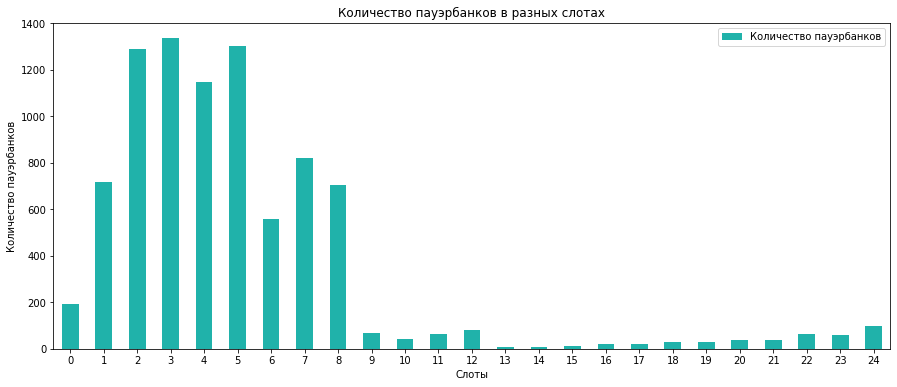

,slot,powerbank_count,percentage
0,0,191,2
1,1,717,8
2,2,1287,15
3,3,1335,15
4,4,1145,13
5,5,1302,15
6,6,556,6
7,7,822,9
8,8,703,8
9,9,68,1


Общее число станций:  8737


In [29]:
# создадим сводную таблицу с данными по числу слотов и количеству станций
slots = pb_csv.pivot_table(index = 'slot', values = 'powerBankId', aggfunc='nunique').sort_values(by='slot').reset_index()

# построим гистограмму
slots.plot(x='slot', 
                          y='powerBankId', 
                          kind='bar', 
                          title='Количество пауэрбанков в разных слотах',
                          label='Количество пауэрбанков',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Слоты')
plt.ylabel('Количество пауэрбанков')
plt.xticks(rotation=0)
plt.show()

slots = slots.rename(columns={'powerBankId': 'powerbank_count'})
slots['percentage'] = round(((slots['powerbank_count'] / slots['powerbank_count'].sum())*100), 2)
display(slots)
print('Общее число станций: ', slots['powerbank_count'].sum())

Благодаря сайту компании мы знаем, что существуют станции на 4, 8, 24 и 48 слотов. Раньше выпускали также модели на 6 слотов. Слотов больше 24 на нашем графике нет, а значит такую большую станцию пока никто не приобрел.

Посмотрим на статусы пауэрбанков, содержащих в столбце slot 0.

In [30]:
check_slot = pb_csv[pb_csv['slot'] == 0].pivot_table(index = 'status', values = 'powerBankId', aggfunc='count').sort_values(by='powerBankId', ascending=False).reset_index()
check_slot = check_slot.rename(columns={'powerBankId': 'powerbank_count'})

# # построим гистограмму
# check_slot.plot(x='status', 
#                           y='powerbank_count', 
#                           kind='bar', 
#                           title='Статусы пауэрбанков со значением 0 в столбце slot',
#                           label='Количество пауэрбанков',
#                           figsize=(15,6),
#                           color='lightseagreen'
# )
# plt.xlabel('Статус пауэрбанка')
# plt.ylabel('Количество пауэрбанков')
# plt.xticks(rotation=0)
# plt.show()


# check_slot['percentage'] = round(((check_slot['powerbank_count'] / check_slot['powerbank_count'].sum())*100), 2)
display(check_slot)
print('Общее число станций: ', check_slot['powerbank_count'].sum())

,status,powerbank_count
0,RENTED,191


Общее число станций:  191


Все устройства с 0 в столбце `slot` взяты в аренду, наше предположение оказалось верным.

**1.2. Статусы пауэрбанков**

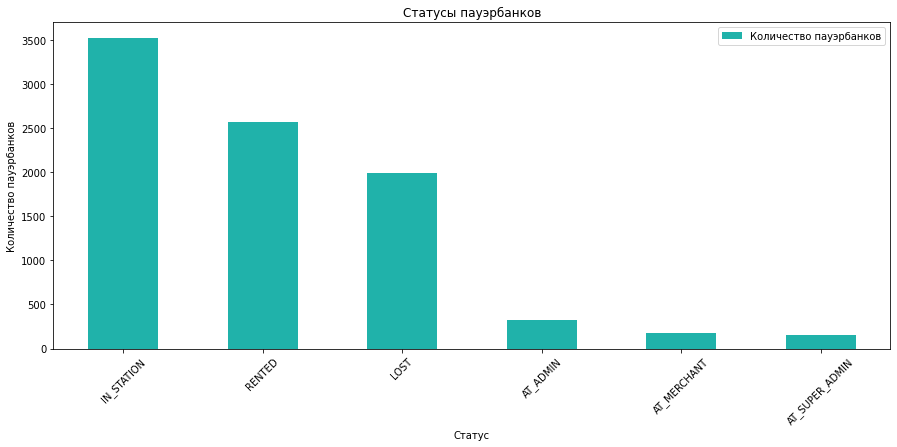

,status,powerbank_count,percentage
0,IN_STATION,3523,40
1,RENTED,2572,29
2,LOST,1992,23
3,AT_ADMIN,321,4
4,AT_MERCHANT,171,2
5,AT_SUPER_ADMIN,158,2


Общее число пауэрбанков:  8737


In [31]:
# создадим сводную таблицу с данными по статусам
status = pb_csv.pivot_table(index = 'status', values = 'powerBankId', aggfunc='nunique').sort_values(by='powerBankId', ascending=False).reset_index()

# построим гистограмму
status.plot(x='status', 
                          y='powerBankId', 
                          kind='bar', 
                          title='Статусы пауэрбанков',
                          label='Количество пауэрбанков',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Статус')
plt.ylabel('Количество пауэрбанков')
plt.xticks(rotation=45)
plt.show()

status = status.rename(columns={'powerBankId': 'powerbank_count'})
status['percentage'] = round(((status['powerbank_count'] / status['powerbank_count'].sum())*100), 2)
display(status)
print('Общее число пауэрбанков: ', status['powerbank_count'].sum())

40% пауэрбанков находятся на станциях, 29% — в аренде, 23% (22,8%, если быть точнее) утеряны.

Находящихся на обслуживании пауэрбанков — 5,48%.

У франчайзи находится всего 2% от всех пауэрбанков, так же как и у самой компании. Можем сделать вывод, что проблемы с устройствами происходят не так часто или быстро решаются.

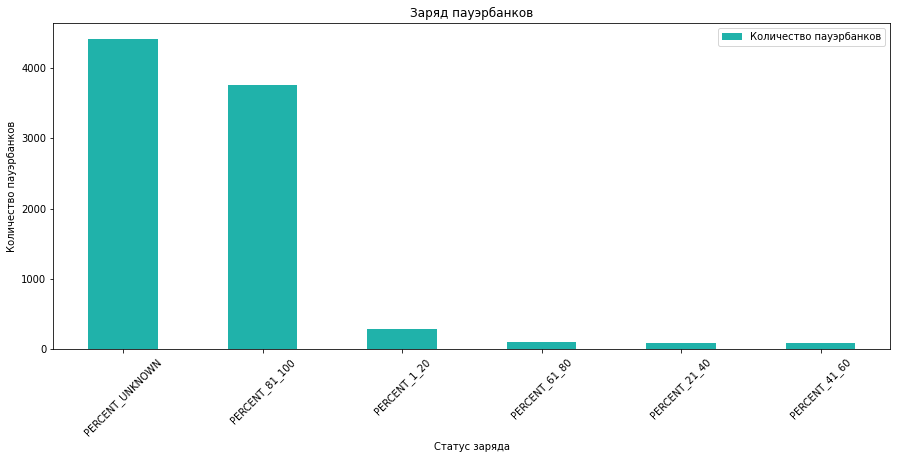

,batteryLevel,powerbank_count,percentage
0,PERCENT_UNKNOWN,4413,51
1,PERCENT_81_100,3750,43
2,PERCENT_1_20,295,3
3,PERCENT_61_80,101,1
4,PERCENT_21_40,89,1
5,PERCENT_41_60,89,1


Общее число пауэрбанков:  8737


In [32]:
# создадим сводную таблицу с данными по статусам заряда
battery_lvl = pb_csv.pivot_table(index = 'batteryLevel', values = 'powerBankId', aggfunc='count').sort_values(by='powerBankId', ascending=False).reset_index()

# построим гистограмму
battery_lvl.plot(x='batteryLevel', 
                          y='powerBankId', 
                          kind='bar', 
                          title='Заряд пауэрбанков',
                          label='Количество пауэрбанков',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Статус заряда')
plt.ylabel('Количество пауэрбанков')
plt.xticks(rotation=45)
plt.show()

battery_lvl = battery_lvl.rename(columns={'powerBankId': 'powerbank_count'})
battery_lvl['percentage'] = round(((battery_lvl['powerbank_count'] / battery_lvl['powerbank_count'].sum())*100), 2)
display(battery_lvl)
print('Общее число пауэрбанков: ', battery_lvl['powerbank_count'].sum())

Мы ничего не знаем о заряде более чем о 50% пауэрбанков.

Возможно, такой большой процент связан с тем, что станции не имеют данных о заряде находящихся в аренде. Но по имеющимся данным у нас 2572 пауэрбанка в аренде, а значит о 1841 просто ничего неизвестно.

Может ли идти речь о потерянных устройствах?

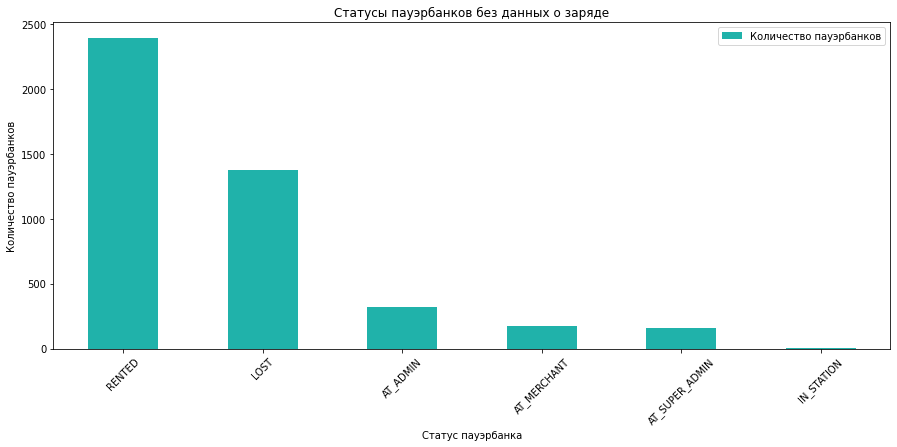

,status,powerbank_count,percentage
0,RENTED,2391,54
1,LOST,1371,31
2,AT_ADMIN,321,7
3,AT_MERCHANT,171,4
4,AT_SUPER_ADMIN,158,4
5,IN_STATION,1,0


Общее число пауэрбанков:  4413


In [33]:
# сформируем таблицу с данными устройств, чей заряд не известен
check_battery_lvl = pb_csv[pb_csv['batteryLevel'] == 'PERCENT_UNKNOWN'].pivot_table(index = 'status', values = 'powerBankId', aggfunc='count').sort_values(by='powerBankId', ascending=False).reset_index()
check_battery_lvl = check_battery_lvl.rename(columns={'powerBankId': 'powerbank_count'})

# построим гистограмму
check_battery_lvl.plot(x='status', 
                          y='powerbank_count', 
                          kind='bar', 
                          title='Статусы пауэрбанков без данных о заряде',
                          label='Количество пауэрбанков',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Статус пауэрбанка')
plt.ylabel('Количество пауэрбанков')
plt.xticks(rotation=45)
plt.show()


check_battery_lvl['percentage'] = round(((check_battery_lvl['powerbank_count'] / check_battery_lvl['powerbank_count'].sum())*100), 2)
display(check_battery_lvl)
print('Общее число пауэрбанков: ', check_battery_lvl['powerbank_count'].sum())

Больше половины пауэрбанков, данных о заряде которых нет, действительно находятся в аренде.

Чуть больше 31% — потерянные пауэрбанки. Получается, что не у всех "потеряшек" отсутствуют данные о заряде — у 621 устройства заряд отображается. Не обновились данные при присвоении статуса?

Остальные — попавшие в ремонт и находящиеся у партнеров.

Теперь посмотрим на столбец `blocked`.

**1.3. Блокировка пауэрбанков**

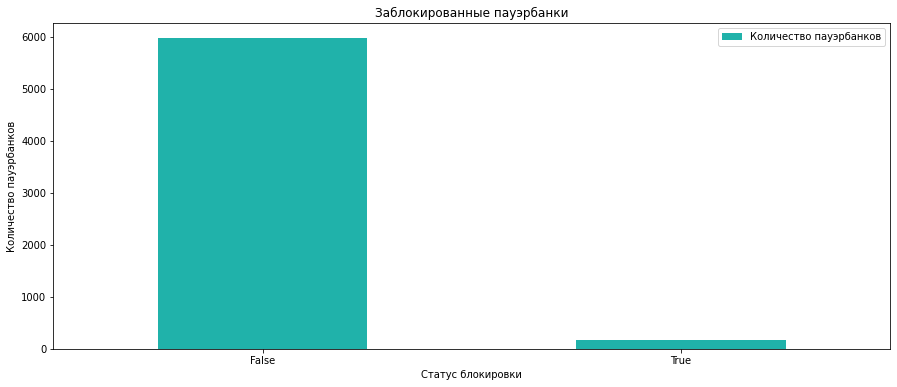

,blocked,powerbank_count,percentage
0,False,5974,97
1,True,171,3


Общее число пауэрбанков:  6145
Отсутствуют данные:  2592


In [34]:
# создадим сводную таблицу с данными по статусам
blocked = pb_csv.pivot_table(index = 'blocked', values = 'powerBankId', aggfunc='count').sort_values(by='powerBankId', ascending=False).reset_index()

# построим гистограмму
blocked.plot(x='blocked', 
                          y='powerBankId', 
                          kind='bar', 
                          title='Заблокированные пауэрбанки',
                          label='Количество пауэрбанков',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Статус блокировки')
plt.ylabel('Количество пауэрбанков')
plt.xticks(rotation=0)
plt.show()

blocked = blocked.rename(columns={'powerBankId': 'powerbank_count'})
blocked['percentage'] = round(((blocked['powerbank_count'] / blocked['powerbank_count'].sum())*100), 2)
display(blocked)
print('Общее число пауэрбанков: ', blocked['powerbank_count'].sum())
print('Отсутствуют данные: ', pb_csv['blocked'].isna().sum())

Не обо всех устройствах есть данные — сбой сбора информации?

Количество заблокированных устройств по данным формата .csv совпадает с количеством устройств со статусом AT_MERCHANT. Проверим, не одни ли и те же это устройства.

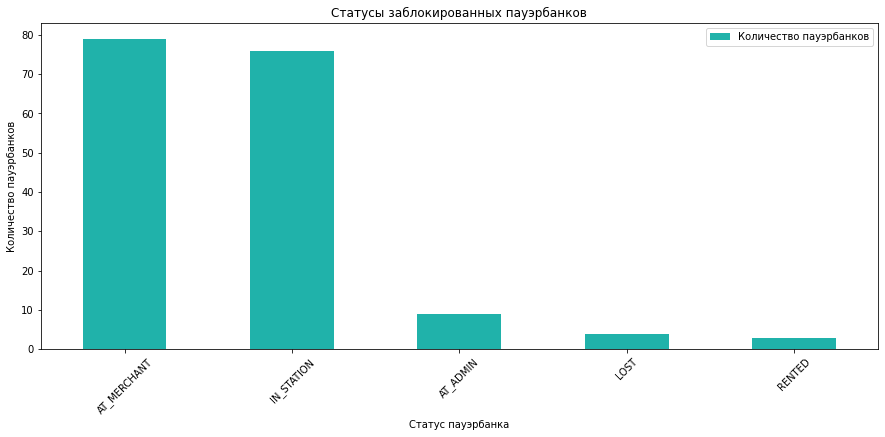

,status,powerbank_count,percentage
0,AT_MERCHANT,79,46
1,IN_STATION,76,44
2,AT_ADMIN,9,5
3,LOST,4,2
4,RENTED,3,2


Общее число пауэрбанков:  171


In [35]:
check_blocked = pb_csv[pb_csv['blocked'] == True].pivot_table(index = 'status', values = 'powerBankId', aggfunc='count').sort_values(by='powerBankId', ascending=False).reset_index()
check_blocked = check_blocked.rename(columns={'powerBankId': 'powerbank_count'})

# построим гистограмму
check_blocked.plot(x='status', 
                          y='powerbank_count', 
                          kind='bar', 
                          title='Статусы заблокированных пауэрбанков',
                          label='Количество пауэрбанков',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Статус пауэрбанка')
plt.ylabel('Количество пауэрбанков')
plt.xticks(rotation=45)
plt.show()


check_blocked['percentage'] = round(((check_blocked['powerbank_count'] / check_blocked['powerbank_count'].sum())*100), 2)
display(check_blocked)
print('Общее число пауэрбанков: ', check_blocked['powerbank_count'].sum())

Гипотеза о том, что все заблокированные устройства имеют статус AT_MERCHANT, не подтвердилась. Да, большая их часть действительно с этим статусом, но также многие находятся на станциях, чуть более 5% в ремонте, 2,3% утеряны, а три пауэрбанка вообще находятся в аренде, чего не должно было быть.

**1.4. Вывод**

Судя по результатам анализа статусов пауэрбанков, можно сделать вывод, что не так много «банок» находится в ремонте, что говорит либо о быстром обслуживании, либо о том, что в принципе поломки происходят нечасто.

Стоит обратить внимание на потерянные пауэрбанки — почти 23% устройств имеют статус LOST, это довольно большой процент.

Отображается статус и объем заряда более чем у 31% потерянных станций.

У 42% пауэрбанков нет данных о статусе блокировки.

Несколько пауэрбанков со статусом blocked находятся в аренде. 

**2. Станции**

Теперь обратимся к датасету, содержащему данные о станциях.

`_id` — уникальный номер записи;

`additionalAddress` — название заведения, где расположена станция;

`additionalImagesCount` — фотографии заведения (?);

`address` — адрес заведения;

`blockedSlots` — заблокированные слоты станции;

`comment` — комментарии;

`connectedAddress` — IP-адрес (?);

`connectionMode` — тип соединения (?);

`created` — дата внесения данных о станции (?);

`csq` — уровень сигнала;

`firmwareVersion` — версия ПО станции;

`groupTariffs._id` — уникальный номер записи из таблицы *groupTariffs*;

`groupTariffs.groupName` — к какой группе тарифов относится;

`groupTariffs.location` — на какой территории действует тариф;

`groupTariffs.periodCount` — период тарифа;

`groupTariffs.tariffType` — тип тарифа;

`groupTariffs.tariffs` — уникальный номер записи из таблицы tariffs;

`latitude` — широта;

`blocked` — блокировка станции;

`longitude` — долгота;

`numberSlots` — количество слотов станции;

`owner` — владелец станции (?);

`simCardId` — ID сим-карты для подключения станции к сети;

`stationID` — ID станции;

`stationNumber` — номер станции;

`status` — статус;

`statusAt` — дата статуса;

`timezone` — часовой пояс;

`voiceLevel` — звуковое оповещение(?);

`workTime.friday` [...] — время работы каждый день недели.

**2.1. Предобработка датасета**

In [36]:
print(stations.shape)
display(stations.head())
print('\033[1m' + 'Информация о датафрейме' + '\033[0m')
print(stations.info())
print()
print('\033[1m' + 'Количество пропусков' + '\033[0m')
print(stations.isnull().sum())
print()
print('\033[1m' + 'Количество дубликатов' + '\033[0m')
print(stations.duplicated().sum())

(905, 37)


,_class,_id,additionalAddress,additionalImagesCount,address,blockedSlots,comment,connectedAddress,connectionMode,created,...,statusAt,timezone,voiceLevel,workTime.friday,workTime.monday,workTime.saturday,workTime.sunday,workTime.thursday,workTime.tuesday,workTime.wednesday
0,com.zaryad.zaryad.backend.common.model.station...,5f21c99bab9b8138c47a00f1,Mandarin Fly кофейня,0,"Кабардино-Балкарская Республика, Нальчик, Каба...",[],NaN,10.128.0.29,LTE,2021-12-03T18:51:22.474Z,...,2022-11-15T11:53:24.805Z,GMT+04:00,0,NaN,"[""ANYTIME""]",NaN,NaN,NaN,NaN,NaN
1,com.zaryad.zaryad.backend.common.model.station...,5f2711c2ab9b8102966c249c,Гости,0,"Ростов-на-Дону, Комарова 30/1",NaN,NaN,10.128.0.29,NaN,2021-12-03T18:50:20.374Z,...,2021-10-02T06:39:10.835Z,GMT+04:00,0,NaN,"[""ANYTIME""]",NaN,NaN,NaN,NaN,NaN
2,com.zaryad.zaryad.backend.common.model.station...,5f29853cab9b8102966c26c6,Кафе Мангальная,3,"Белгород, ул. Есенина, 9, корп. 4.",[],"+79511388133 Евгений, администратор",10.128.0.29,LTE,2022-02-13T18:28:31.265Z,...,2022-11-15T11:53:16.262Z,GMT+03:00,0,"[""10:00"",""00:00""]","[""10:00"",""00:00""]","[""10:00"",""00:00""]","[""10:00"",""00:00""]","[""10:00"",""00:00""]","[""10:00"",""00:00""]","[""10:00"",""00:00""]"
3,com.zaryad.zaryad.backend.common.model.station...,5f2985d0ab9b8102966c26c7,Zамания игровое кафе,0,"Москва, Ходынский бульвар, 4",[],NaN,10.128.0.29,LTE,2022-03-07T16:30:55.077Z,...,2022-11-15T11:53:26.518Z,GMT+04:00,0,NaN,"[""ANYTIME""]",NaN,NaN,NaN,NaN,NaN
4,com.zaryad.zaryad.backend.common.model.station...,5f298701ab9b8102966c26ce,Zамания игровое кафе,0,"Москва, Рублёвское шоссе, д 68А стр 5",[],NaN,10.128.0.29,LTE,2022-03-07T16:30:36.135Z,...,2022-11-15T11:53:20.242Z,GMT+04:00,0,NaN,"[""ANYTIME""]",NaN,NaN,NaN,NaN,NaN


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _class                    905 non-null    object 
 1   _id                       905 non-null    object 
 2   additionalAddress         905 non-null    object 
 3   additionalImagesCount     905 non-null    int64  
 4   address                   905 non-null    object 
 5   blockedSlots              875 non-null    object 
 6   comment                   69 non-null     object 
 7   connectedAddress          903 non-null    object 
 8   connectionMode            842 non-null    object 
 9   created                   905 non-null    object 
 10  csq                       905 non-null    int64  
 11  firmwareVersion           901 non-null    object 
 12  groupTariffs._id          905 non-null    object 
 13  groupTariffs.groupName    905 non-null   

Дубликатов не обнаружено, есть пропуски в данных о: 

- заблокированных слотах станций; 
- версии ПО; 
- типе тарифа; 
- владельце; 
- статусе и времени его появления; 
- времени работы заведения, где установлена станция; 
- комментариях; 
- адресе и типе соединения.

Поправим типы данных.

In [37]:
stations['created'] = pd.to_datetime(stations['created'])
stations['statusAt'] = pd.to_datetime(stations['statusAt'])

# удалим ненужный нам столбец _class
stations = stations.drop(['_class'], axis=1)

Датасет заимствует все данные из датасета group_tariffs.

Имеется 905 станций. Посмотрим, в какой период были созданы эти станции.

Для начала убедимся, что в датасете нет дубликатов по ID.

In [38]:
stations['stationID'].duplicated().sum()

0

In [39]:
rents['startDate'] = pd.to_datetime(rents['startDate'])

print('\033[1m' + 'Временной период создания терминалов' + '\033[0m')
print('Самая ранняя дата создания терминала:', stations['created'].min())
print('Самая поздняя дата создания терминала:', stations['created'].max())
print()
print('Самая ранняя дата статуса:', stations['statusAt'].min())
print('Самая поздняя дата статуса:', stations['statusAt'].max())
print()
print('Самая ранняя аренда:', rents['startDate'].min())
print('Самая поздняя аренда:', stations['statusAt'].max())

Временной период создания терминалов
Самая ранняя дата создания терминала: 2021-05-04 19:00:44.947000+00:00
Самая поздняя дата создания терминала: 2022-11-15 01:38:17.787000+00:00

Самая ранняя дата статуса: 2021-04-09 15:31:20.243000+00:00
Самая поздняя дата статуса: 2022-11-15 11:53:44.387000+00:00

Самая ранняя аренда: 2020-05-27 09:43:24.320000+00:00
Самая поздняя аренда: 2022-11-15 11:53:44.387000+00:00


Самая ранняя дата создания терминала — 4 мая 2021 года, тогда как самая ранняя дата статуса — 9 апреля 2021 года. 

Скорее всего, это несоответствие указывает на то, что мы неверно трактовали смысл данных в столбце `created`. Но нельзя исключать и неточность в сборе данных по станциям.

Посмотрим на заблокированные слоты и станции.

**2.2. Заблокированные станции**

In [40]:
stations['blockedSlots'].unique()

array(['[]', nan], dtype=object)

Заблокированных слотов в имеющихся станциях нет.

Есть ли заблокированные станции?

In [41]:
st_loked = stations.pivot_table(index='locked', values='stationID', aggfunc='count')
st_loked

,stationID
locked,
False,904
True,1


Имеется только одна заблокированная станция. Посмотрим на данные это станции поближе.

In [42]:
stations[['additionalAddress', 'address', 'comment', 'created', 'csq', 'status', 'statusAt', 'locked']].query('locked == True')

,additionalAddress,address,comment,created,csq,status,statusAt,locked
30,Пинта,"Ростов-на Дону, Ворошиловский 62",Station is blocked due to not checking powerBank,2021-12-08 16:26:50.700000+00:00,0,CONNECTED,2022-11-15 11:53:35.085000+00:00,True


Станция заблокирована, так как не проверена.

Есть ли еще станции с таким комментарием и какой у них статус?

In [43]:
st_with_block_comment = (
    stations[['additionalAddress', 'stationID', 'comment', 'csq', 'status', 'statusAt']]
    .query('comment == "Station is blocked due to not checking powerBank"')
    .pivot_table(index='status', values='stationID', aggfunc='nunique')
    .reset_index()
)
st_with_block_comment = st_with_block_comment.rename(columns={'stationID': 'station_count'})
st_with_block_comment

,status,station_count
0,CONNECTED,42
1,DISCONNECTED,6


Большая часть станций с комментарием о блокировке обозначены как работающие. Скорее всего, комментарий был добавлен в момент установки или неполадки или заблокированные станции все еще подключены к интернету.

Посмотрим на число слотов в имеющихся станциях.

**2.3. Количество слотов в станциях**

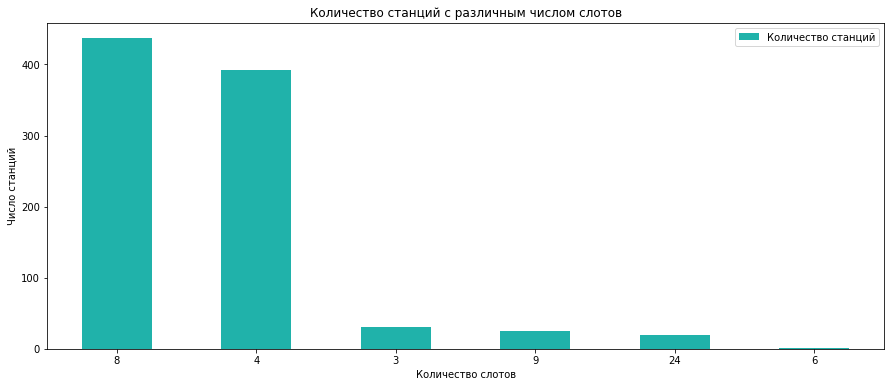

,numberSlots,station_count,percentage
0,8,437,48
1,4,392,43
2,3,30,3
3,9,25,3
4,24,20,2
5,6,1,0


Общее число станций:  905


In [44]:
nb_slots = stations.pivot_table(index='numberSlots', values='stationID', aggfunc='count')
nb_slots = nb_slots.rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
nb_slots.plot(x='numberSlots', 
                          y='station_count', 
                          kind='bar', 
                          title='Количество станций с различным числом слотов',
                          label='Количество станций',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Количество слотов')
plt.ylabel('Число станций')
plt.xticks(rotation=0)
plt.show()


nb_slots['percentage'] = round(((nb_slots['station_count'] / nb_slots['station_count'].sum())*100), 2)
display(nb_slots)
print('Общее число станций: ', nb_slots['station_count'].sum())

Наибольшее число станций – ок. 48,3% – имеют восемь слотов, 43,3% – четыре слота. Далее с внушительным отрывом следуют все остальные терминалы, их примерно одинаковое количество, лишь станции с шестью слотами представлены минимально – всего в одном экземпляре.

Отметим, что из текущего модельного ряда здесь представлены станции с 4, 8 и 24 слотами, есть станция с 6 слотами, которая, видимо, больше не выпускается. Также присутсвуют станции с 3 и 9 слотами — о них не удалось найти никакой информации, будем считать, что это также старые модели.

Проверим, совпадает ли число имеющихся пауэрбанков с числом слотов.

In [45]:
nb_slots['station_sum'] = nb_slots['station_count'] * nb_slots['numberSlots']
nb_slots['station_sum'].sum()

5865

Слотов оказалось меньше, чем информации по имеющимся пауэрбанкам даже с вычетом утерянных. Вероятно, запасные устройства позволяют легко заменять вышедшие из строя и довозить туда, где их почти не осталось.

Обратимся к заведениям, в которых стоят терминалы.

**2.4. Заведения, где размещены станции**

Названия заведений или адреса могут быть написаны с ошибками, поэтому проверим, есть ли дубликаты, опираясь на ID станций.

In [46]:
stations['stationID'].duplicated().sum()

0

Каждая запись в таблице уникальна.

In [47]:
# приведем названия заведений к нижнему регистру
stations['additionalAddress'] = stations['additionalAddress'].str.lower()

In [48]:
# функция определения типа заведения
def objects_type(object_name): 
    if 'ресто' in object_name or 'restaurant' in object_name or 'тракт' in object_name or 'траттор' in object_name or 'грил' in object_name or 'стейк' in object_name: 
        return 'ресторан'
    if 'коф' in object_name or 'каф' in object_name or 'пекарня' in object_name or 'cof' in object_name or 'cafe' in object_name or 'чайх' in object_name or 'пиццерия' in object_name:
        return 'кафе/кофейня'
    if 'закусоч' in object_name or 'хачапур' in object_name or 'хинкал' in object_name or 'бистр' in object_name or 'буфет' in object_name or 'пышеч' in object_name or 'гамбур' in object_name or 'бург' in object_name:
        return 'закусочная'
    if 'bar' in object_name or 'бар' in object_name or 'паб' in object_name or 'pub' in object_name or 'кальян' in object_name:
        return 'бар/паб/кальян'
    if 'кинотеатр' in object_name:
        return 'кинотеатр'
    if 'клуб' in object_name or 'club' in object_name or 'караоке' in object_name:
        return 'клуб/караоке'
    if 'фитне' in object_name or 'fitness' in object_name:
        return 'фитнес-клуб'
    if 'отел' in object_name or 'гостин' in object_name or 'hotel' in object_name:
        return 'отель/гостиница'
    if 'аэроп' in object_name or 'прилет' in object_name or 'терминал' in object_name or 'внуково' in object_name:
        return 'аэропорт'
    if 'кибер' in object_name or 'комп' in object_name or 'cyber' in object_name:
        return 'компьютерный клуб'
    if 'шаурм' in object_name or 'чебур' in object_name or 'киоск' in object_name:
        return 'фастфуд'
    if 'тц' in object_name or 'трц' in object_name or 'трк' in object_name or 'торгов' in object_name or 'молл' in object_name:
        return 'ТРК/ТРЦ'
    if 'вокзал' in object_name:
        return 'вокзал'
    return 'тип не определен'

In [49]:
stations.insert(2, 'objects_type', 0)
stations['objects_type'] = stations['additionalAddress'].apply(objects_type)

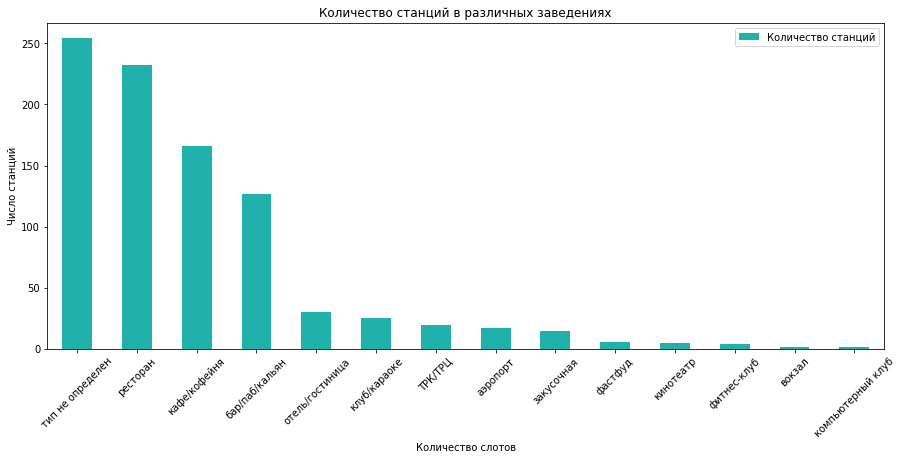

,objects_type,station_count,percentage
0,тип не определен,254,28
1,ресторан,232,26
2,кафе/кофейня,166,18
3,бар/паб/кальян,127,14
4,отель/гостиница,30,3
5,клуб/караоке,25,3
6,ТРК/ТРЦ,20,2
7,аэропорт,17,2
8,закусочная,15,2
9,фастфуд,6,1


Общее число станций:  905


In [50]:
st_in_objects = stations.pivot_table(index='objects_type', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
st_in_objects.plot(x='objects_type', 
                          y='station_count', 
                          kind='bar', 
                          title='Количество станций в различных заведениях',
                          label='Количество станций',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Количество слотов')
plt.ylabel('Число станций')
plt.xticks(rotation=45)
plt.show()


st_in_objects['percentage'] = round(((st_in_objects['station_count'] / st_in_objects['station_count'].sum())*100), 2)
display(st_in_objects)
print('Общее число станций: ', st_in_objects['station_count'].sum())

Не у всех заведений имеется пометка об их типе, но большую часть точек удалось категоризировать.

Наиболее популярным типом заведений является ресторан, на втором месте кафе и кофейни, на третьем — бары. В сумме эти типы составляют больше половины всех мест, где размещены станции (58%).

**2.5. Вывод**

Устройств больше, чем слотов в станциях, мы предположили, что это запасные пауэрбанки, которые позволяют оперативно заменять сломанные или утерянные.

Наиболее популярны станции на 8 слотов, на втором месте 24 слота, на третьем — 4 слота.

Не все точки удалось определить, так как в заполнении данных нет установленной формы: где-то написаны только названия, где-то названия с дополнительной информацией, встречаются ошибки в написании. Лучше разделить дополнительные сведения о точке размещения станции, добавив возможность оставлять комментарий, вывести в отдельный столбец тип заведения.

На первом месте по числу станций рестораны, на втором — кафе и кофейни, на третьем — бары, пабы и кальянные.

**3. Аренда пауэрбанков**

Рассмотрим датасет, содержащий информацию об арендах пауэрбанков.

`_id` — уникальный номер записи;

`completionStation` — адрес станции, куда был возвращен пауэрбанк (?);

`creditCardId` — уникальный номер кредитной карты пользователя;

`currentTariff.nameGroupTariffs` — к какой группе относится тариф;

`currentTariff.period` — период тарифа;

`currentTariff.price` — стоимость пользования;

`currentTariff.tariffName` — название тарифа;

`currentTariff.timeForWork` — время действия тарифа;

`currentTariff.workingTimeInterval` — временной интервал работы тарифа;

`debt` — долг пользователя по оплате;

`finishedDate` — дата и время завершения аренды;

`groupTariffs._id` — продублирована полностью таблица *groupTariffs*;

`notificationStatus` — уведомление о статусе (?);

`price` — цена;

`rentStatust` — статус аренды;

`startDate` — дата и время начала аренды;

`startStation` — станция, с которой взяли пауэрбанк;

`stationID` —  ID станции;

`stationNumber` — номер станции;

`tariffText.locationForTariff` — локация тарифа;

`tariffText.tariffText` — тариф (?);

`totalAmount` — начисления;

`transaction` — переводы;

`updateDate` — дата обновления данных;

`user._id` — уникальный номер записи в таблице *users*;

`user.blocking` — блокировка пользователя;

`user.createdDate` — дата создания аккаунта (?);

`user.roles` — роль;

`user.TelegramChatId` — идентификатор Телеграм-чата;

`user.TelegramLoginState` — использование сервиса через Телеграм;

`user.Webuser` — использование сервиса через браузер.

**3.1. Предобработка датасета**

In [51]:
print(rents.shape)
display(rents.head())
print('\033[1m' + 'Информация о датафрейме' + '\033[0m')
print(rents.info())
print()
print('\033[1m' + 'Количество пропусков' + '\033[0m')
print(rents.isnull().sum())
print()
print('\033[1m' + 'Количество дубликатов' + '\033[0m')
print(stations.duplicated().sum())

(219583, 37)


,_id,completionStation,creditCardId,currentTariff.nameGroupTariffs,currentTariff.period,currentTariff.price,currentTariff.tariffName,currentTariff.timeForWork,currentTariff.typeTime,currentTariff.workingTimeInterval,...,totalAmount,transaction,updatedDate,user._id,user.blocking,user.createdDate,user.roles,user.telegramChatId,user.telegramLoginState,user.webUser
0,5ece363cab9b814d8716a6f0,"Нальчик, ул.Льва Толстого 18",5ece35c3ab9b814d8716a6ef,NaN,1,0,Промо,1,HOUR,0,...,0,['5ece363cab9b814d8716a6f1'],2020-05-27T09:43:24.329Z,5ece331eab9b814d8716a6ea,False,2020-05-27T09:30:06.148Z,"[{""role"":""USER""}]",NaN,False,True
1,5ece45a5ab9b814d8716a703,"Нальчик, ул.Льва Толстого 18",5ece35c3ab9b814d8716a6ef,NaN,2,50,Час 50 рублей,2,HOUR,1,...,50,"['5ece45a9ab9b814d8716a705', '5ece45a9ab9b814d...",2020-05-27T10:49:13.375Z,5ece331eab9b814d8716a6ea,False,2020-05-27T09:30:06.148Z,"[{""role"":""USER""}]",NaN,False,True
2,5ecfd910ab9b815292b21712,"Нальчик, ул.Льва Толстого 18",5ece35c3ab9b814d8716a6ef,NaN,1,0,Промо,1,HOUR,0,...,0,['5ecfd910ab9b815292b21713'],2020-05-28T15:30:24.921Z,5ece331eab9b814d8716a6ea,False,2020-05-27T09:30:06.148Z,"[{""role"":""USER""}]",NaN,False,True
3,5ed7b00bab9b811856f6cab3,"Нальчик, ул.Льва Толстого 18",5ece35c3ab9b814d8716a6ef,NaN,1,0,Промо,1,HOUR,0,...,0,['5ed7b00bab9b811856f6cab4'],2020-06-03T14:13:31.534Z,5ece331eab9b814d8716a6ea,False,2020-05-27T09:30:06.148Z,"[{""role"":""USER""}]",NaN,False,True
4,5ee7ab76ab9b81710d8ab8db,"Нальчик, ул.Льва Толстого 18",5ee7ab6cab9b81710d8ab8da,NaN,1,0,Промо,1,HOUR,0,...,0,['5ee7ab76ab9b81710d8ab8dc'],2020-06-15T17:10:14.076Z,5ece331eab9b814d8716a6ea,False,2020-05-27T09:30:06.148Z,"[{""role"":""USER""}]",NaN,False,True


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219583 entries, 0 to 219582
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype              
---  ------                             --------------   -----              
 0   _id                                219583 non-null  object             
 1   completionStation                  219254 non-null  object             
 2   creditCardId                       219046 non-null  object             
 3   currentTariff.nameGroupTariffs     78669 non-null   object             
 4   currentTariff.period               219583 non-null  int64              
 5   currentTariff.price                219583 non-null  float64            
 6   currentTariff.tariffName           219583 non-null  object             
 7   currentTariff.timeForWork          219583 non-null  int64              
 8   currentTariff.typeTime             219583 non-null  object             
 9   currentTariff

Дубликатов не обнаружено, есть пропуски в данных о тарифах, кредитных картах, дате завершения (скорее всего, еще длящиеся аренды), ID пауэрбанков и телеграм-чата. Эти пропуски на данном этапе не имеют для нас значения, поэтому удалять их пока не будем.

In [52]:
# исправим типы данных
rents['finishedDate'] = pd.to_datetime(rents['finishedDate'])
rents['updatedDate'] = pd.to_datetime(rents['updatedDate'])
rents['user.createdDate'] = pd.to_datetime(rents['user.createdDate'])

**3.2. Подготовка к анализу**

Посмотрим на статусы аренды.

In [53]:
rents['rentStatus'].unique()

array(['FINISHED', 'INIT', 'PROCESSING'], dtype=object)

У нас имеется три статуса:

- INIT — только инициированный, оплата пока не поступила;
- PROCESSING — аренда в процессе, уже могли быть оплаты в зависимости от периода аренды;
- FINISHED — аренда завершилась, все оплаты совершены или сумма зачислена в долг.

Чтобы оценить доход станций, отберем только закончившиеся аренды.

In [54]:
finished_rents = rents[['_id', 'debt', 'rentStatus', 'stationID', 'powerBankID', 'startDate', 'finishedDate', 'startStation', 'price', 'currentTariff.period', 'totalAmount', 'transaction']].query('rentStatus == "FINISHED"')
finished_rents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219335 entries, 0 to 219569
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   _id                   219335 non-null  object             
 1   debt                  219335 non-null  float64            
 2   rentStatus            219335 non-null  object             
 3   stationID             219335 non-null  object             
 4   powerBankID           218706 non-null  float64            
 5   startDate             219335 non-null  datetime64[ns, UTC]
 6   finishedDate          219276 non-null  datetime64[ns, UTC]
 7   startStation          219335 non-null  object             
 8   price                 219335 non-null  float64            
 9   currentTariff.period  219335 non-null  int64              
 10  totalAmount           219335 non-null  float64            
 11  transaction           219335 non-null  object       

Добавим данные о месторасположении станции.

In [55]:
# подготовим таблицу с необходимыми данными
# отберем только нужное из таблицы stations
stations_object = stations[['stationID', 'status', 'statusAt', 'additionalAddress', 'objects_type', 'address', 'numberSlots', 'groupTariffs.location']]
display(stations_object.head(3))
stations_object.info()
print()
print('\033[1m' + 'Количество дубликатов' + '\033[0m')
print(stations.duplicated().sum())

,stationID,status,statusAt,additionalAddress,objects_type,address,numberSlots,groupTariffs.location
0,RL3H081907640181,CONNECTED,2022-11-15 11:53:24.805000+00:00,mandarin fly кофейня,кафе/кофейня,"Кабардино-Балкарская Республика, Нальчик, Каба...",8,RU
1,DONB031901810097,DISCONNECTED,2021-10-02 06:39:10.835000+00:00,гости,тип не определен,"Ростов-на-Дону, Комарова 30/1",3,RU
2,FFRH082006200044,CONNECTED,2022-11-15 11:53:16.262000+00:00,кафе мангальная,кафе/кофейня,"Белгород, ул. Есенина, 9, корп. 4.",8,RU


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   stationID              905 non-null    object             
 1   status                 903 non-null    object             
 2   statusAt               903 non-null    datetime64[ns, UTC]
 3   additionalAddress      905 non-null    object             
 4   objects_type           905 non-null    object             
 5   address                905 non-null    object             
 6   numberSlots            905 non-null    int64              
 7   groupTariffs.location  905 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(1), object(6)
memory usage: 56.7+ KB

Количество дубликатов
0


In [56]:
# соединим получившийся датасет с finished_rents
finished_rents = finished_rents.merge(stations_object, on='stationID', how='left')
finished_rents = finished_rents.rename(columns={'_id': 'rentId', 'address': 'stationAddress', 'status': 'stationStatus', 'statusAt': 'stationStatusAt'})
finished_rents = finished_rents[['rentId', 'stationID', 'numberSlots', 'powerBankID', 'startDate', 'finishedDate', 'stationAddress', 'startStation', 'stationStatus', 'stationStatusAt', 'objects_type', 'currentTariff.period', 'groupTariffs.location', 'price', 'totalAmount', 'debt', 'transaction']]
display(finished_rents.head(5))
finished_rents.info()

,rentId,stationID,numberSlots,powerBankID,startDate,finishedDate,stationAddress,startStation,stationStatus,stationStatusAt,objects_type,currentTariff.period,groupTariffs.location,price,totalAmount,debt,transaction
0,5ece363cab9b814d8716a6f0,RL3H081907470168,NaN,5930171196289065984,2020-05-27 09:43:24.320000+00:00,2020-05-27 09:53:54.608000+00:00,NaN,"Нальчик, ул.Льва Толстого 18",NaN,NaT,NaN,1,NaN,0,0,0,['5ece363cab9b814d8716a6f1']
1,5ece45a5ab9b814d8716a703,RL3H081907470168,NaN,5930171196289065984,2020-05-27 10:49:09.277000+00:00,2020-05-27 10:52:21.733000+00:00,NaN,"Нальчик, ул.Льва Толстого 18",NaN,NaT,NaN,2,NaN,50,50,0,"['5ece45a9ab9b814d8716a705', '5ece45a9ab9b814d..."
2,5ecfd910ab9b815292b21712,RL3H081907470168,NaN,5930171196289065984,2020-05-28 15:30:24.919000+00:00,2020-05-28 15:34:24.877000+00:00,NaN,"Нальчик, ул.Льва Толстого 18",NaN,NaT,NaN,1,NaN,0,0,0,['5ecfd910ab9b815292b21713']
3,5ed7b00bab9b811856f6cab3,RL3H081907470168,NaN,5930171196289065984,2020-06-03 14:13:31.511000+00:00,2020-06-03 14:20:11.201000+00:00,NaN,"Нальчик, ул.Льва Толстого 18",NaN,NaT,NaN,1,NaN,0,0,0,['5ed7b00bab9b811856f6cab4']
4,5ee7ab76ab9b81710d8ab8db,RL3H081907470168,NaN,5930171196289065984,2020-06-15 17:10:14.073000+00:00,2020-06-15 18:07:53.285000+00:00,NaN,"Нальчик, ул.Льва Толстого 18",NaN,NaT,NaN,1,NaN,0,0,0,['5ee7ab76ab9b81710d8ab8dc']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 219335 entries, 0 to 219334
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   rentId                 219335 non-null  object             
 1   stationID              219335 non-null  object             
 2   numberSlots            211881 non-null  float64            
 3   powerBankID            218706 non-null  float64            
 4   startDate              219335 non-null  datetime64[ns, UTC]
 5   finishedDate           219276 non-null  datetime64[ns, UTC]
 6   stationAddress         211881 non-null  object             
 7   startStation           219335 non-null  object             
 8   stationStatus          211878 non-null  object             
 9   stationStatusAt        211878 non-null  datetime64[ns, UTC]
 10  objects_type           211881 non-null  object             
 11  currentTariff.period   219335 non-null 

In [57]:
# добавим инфу о последних станциях пауэрбанков
last_stations = pb_csv[['lastStation', 'powerBankId']].rename(columns={'powerBankId': 'powerBankID'})
finished_rents = pd.merge(finished_rents, last_stations, on='powerBankID', how='left')

# добавим инфу об адресах последних станций
last_stations_address = stations[['_id', 'address', 'status']].rename(columns={'_id': 'lastStation', 'address': 'lastStationAddress', 'status': 'lastStationStatus'})
finished_rents = pd.merge(finished_rents, last_stations_address, on='lastStation', how='left')
finished_rents = finished_rents[['rentId', 'stationID', 'stationStatus', 'stationStatusAt', 'numberSlots', 'powerBankID', 'startDate', 'finishedDate', 'stationAddress', 'startStation', 'lastStationAddress', 'lastStationStatus', 'objects_type', 'currentTariff.period', 'groupTariffs.location', 'price', 'totalAmount', 'debt', 'transaction']]
display(finished_rents.head(3))
finished_rents.info()
print()
print('\033[1m' + 'Количество пропусков' + '\033[0m')
print(rents.isnull().sum())
print()
print('\033[1m' + 'Количество дубликатов' + '\033[0m')
print(stations.duplicated().sum())

,rentId,stationID,stationStatus,stationStatusAt,numberSlots,powerBankID,startDate,finishedDate,stationAddress,startStation,lastStationAddress,lastStationStatus,objects_type,currentTariff.period,groupTariffs.location,price,totalAmount,debt,transaction
0,5ece363cab9b814d8716a6f0,RL3H081907470168,NaN,NaT,NaN,5930171196289065984,2020-05-27 09:43:24.320000+00:00,2020-05-27 09:53:54.608000+00:00,NaN,"Нальчик, ул.Льва Толстого 18",NaN,NaN,NaN,1,NaN,0,0,0,['5ece363cab9b814d8716a6f1']
1,5ece45a5ab9b814d8716a703,RL3H081907470168,NaN,NaT,NaN,5930171196289065984,2020-05-27 10:49:09.277000+00:00,2020-05-27 10:52:21.733000+00:00,NaN,"Нальчик, ул.Льва Толстого 18",NaN,NaN,NaN,2,NaN,50,50,0,"['5ece45a9ab9b814d8716a705', '5ece45a9ab9b814d..."
2,5ecfd910ab9b815292b21712,RL3H081907470168,NaN,NaT,NaN,5930171196289065984,2020-05-28 15:30:24.919000+00:00,2020-05-28 15:34:24.877000+00:00,NaN,"Нальчик, ул.Льва Толстого 18",NaN,NaN,NaN,1,NaN,0,0,0,['5ecfd910ab9b815292b21713']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 219335 entries, 0 to 219334
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   rentId                 219335 non-null  object             
 1   stationID              219335 non-null  object             
 2   stationStatus          211878 non-null  object             
 3   stationStatusAt        211878 non-null  datetime64[ns, UTC]
 4   numberSlots            211881 non-null  float64            
 5   powerBankID            218706 non-null  float64            
 6   startDate              219335 non-null  datetime64[ns, UTC]
 7   finishedDate           219276 non-null  datetime64[ns, UTC]
 8   stationAddress         211881 non-null  object             
 9   startStation           219335 non-null  object             
 10  lastStationAddress     116129 non-null  object             
 11  lastStationStatus      116129 non-null 

Больше всего данных отсутствует в столбцах с информацией о последней станции пауэрбанка. 

Посмотрим на эти данные поближе, оценим, сколько отключенных и активных станций среди них.

**3.3. Проверка активности станций**

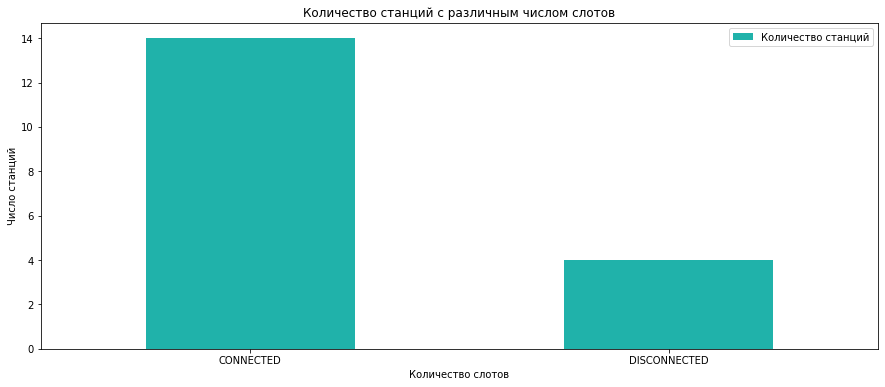

,lastStationStatus,station_count,percentage
0,CONNECTED,14,78
1,DISCONNECTED,4,22


Суммарное число станций:  18
Уникальных станций в столбце lastStationAddress: 18


In [58]:
disc_stations = finished_rents.pivot_table(index='lastStationStatus', values='lastStationAddress', aggfunc='nunique')
disc_stations = disc_stations.rename(columns={'lastStationAddress': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
disc_stations.plot(x='lastStationStatus', 
                          y='station_count', 
                          kind='bar', 
                          title='Количество станций с различным числом слотов',
                          label='Количество станций',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Количество слотов')
plt.ylabel('Число станций')
plt.xticks(rotation=0)
plt.show()


disc_stations['percentage'] = round(((disc_stations['station_count'] / disc_stations['station_count'].sum())*100), 2)
display(disc_stations)
print('Суммарное число станций: ', disc_stations['station_count'].sum())
print('Уникальных станций в столбце lastStationAddress:', finished_rents['lastStationAddress'].nunique())

In [59]:
finished_rents.query('lastStationStatus == "DISCONNECTED"').head(4)

,rentId,stationID,stationStatus,stationStatusAt,numberSlots,powerBankID,startDate,finishedDate,stationAddress,startStation,lastStationAddress,lastStationStatus,objects_type,currentTariff.period,groupTariffs.location,price,totalAmount,debt,transaction
34686,610023aaf3cf124d978dfe6e,FFRH042012620005,NaN,NaT,NaN,5063825300585972736,2021-07-27 15:18:02.350000+00:00,2021-07-27 17:17:42.844000+00:00,NaN,"Москва, Ходынский бульвар, 4","Москва, Рыбников переулок, 1",DISCONNECTED,NaN,3,NaN,100,100,0,"['610023adf3cf124d978dfe72', '61002ab2f3cf124d..."
35051,610286dcf3cf124d978e13fc,FFRH082006640024,CONNECTED,2022-11-15 11:53:19.391000+00:00,8,5063825300585972736,2021-07-29 10:45:48.810000+00:00,2021-09-10 09:44:49.485000+00:00,"Россия, Ставрополь, улица Пушкина, 3","Россия, Ставрополь, Кавалерийская улица, 25А","Москва, Рыбников переулок, 1",DISCONNECTED,кафе/кофейня,2,RU,100,3000,0,"['610286e2f3cf124d978e13fe', '61028a34f3cf124d..."
35415,6104252ae53a8135669681ca,FFRH082006690047,CONNECTED,2022-11-15 11:53:23.357000+00:00,8,5063825300585973760,2021-07-30 16:13:30.318000+00:00,2021-07-30 16:55:39.529000+00:00,"Ставропольский край, г Кисловодск, ул Вокзальн...","Республика Северная Осетия — Алания, Владикавк...","Краснодарский край, г Сочи, ул Роз, д 52",DISCONNECTED,тип не определен,1,RU,100,100,0,"['61042537e53a8135669681cf', '61042537e53a8135..."
35443,61043079e53a813566968379,FFRH082006690047,CONNECTED,2022-11-15 11:53:23.357000+00:00,8,5063825300585973760,2021-07-30 17:01:45.956000+00:00,2021-07-30 18:45:32.105000+00:00,"Ставропольский край, г Кисловодск, ул Вокзальн...","Республика Северная Осетия — Алания, Владикавк...","Краснодарский край, г Сочи, ул Роз, д 52",DISCONNECTED,тип не определен,1,RU,100,100,0,"['6104309be53a81356696837e', '6104309be53a8135..."


У нас всего 18 уникальных станций в столбце lastStationAddress, 4 из которых уже отключены.

Если взглянуть на адреса последних станций, которые имеют статус DISCONNECTED, то видно, что пауэрбанки, чье последнее расположение отмечено в отключенных станциях, появляются после в новых местах, а значит их забирают с отключенных станций и прикрепляют к новым.

Таким образом, `lastStation` не соответствует реальной ситуации в случае, если станция была отключена. Хотя датасет и охватывает указанное время — он включает записи до 11:58 15-го ноября, а старт аренды части пауэрбанков произошел раньше, — последней станцией у них все равно еще значится отключенная. Возможно, это значение указывает последнюю станцию, куда пауэрбанк был возвращен, а не ту, с которой его взяли, тогда в случае перемещения в результате обслуживания станций данные могли быть не записаны.

В датасете *rent* присутвуют ID станций, но адреса их не всегда совпадают с адресами ни стартовых, ни финальных станций. В таком случае не понятно, что это за ID.

In [60]:
# проверка совпадений адресов из столбца stationAddress со столбцом startStation
# test_station_address = finished_rents[['stationAddress']]
# test_station_address = test_station_address.rename(columns={'stationAddress': 'address'})
# test_start_address = finished_rents[['startStation']]
# test_start_address = test_start_address.rename(columns={'startStation': 'address'})

# diff = test_station_address.loc[test_station_address.ne(test_start_address).any(axis=1)]

# diff = diff.dropna().drop_duplicates().reset_index(drop=True)
# diff

Так как деньги получает хозяин станции, с которой берут в аренду пауэрбанк, мы будем опираться на данные в столбце startStation.

Для начала нам определим названия заведений по имеющемуся адресу.

In [61]:
names_of_objects = stations[['additionalAddress', 'address']]
names_of_objects = names_of_objects.rename(columns={'additionalAddress': 'objects_name', 'address': 'startStation'})

finished_rents = pd.merge(finished_rents, names_of_objects[['objects_name', 'startStation']], on='startStation', how='left')
finished_rents = finished_rents.rename(columns={'groupTariffs.location': 'location'})
display(finished_rents.head(4))
finished_rents.info()
print()
print('\033[1m' + 'Количество пропусков' + '\033[0m')
print(finished_rents.isnull().sum())
print()
print('\033[1m' + 'Количество дубликатов' + '\033[0m')
print(finished_rents.duplicated().sum())

,rentId,stationID,stationStatus,stationStatusAt,numberSlots,powerBankID,startDate,finishedDate,stationAddress,startStation,lastStationAddress,lastStationStatus,objects_type,currentTariff.period,location,price,totalAmount,debt,transaction,objects_name
0,5ece363cab9b814d8716a6f0,RL3H081907470168,NaN,NaT,NaN,5930171196289065984,2020-05-27 09:43:24.320000+00:00,2020-05-27 09:53:54.608000+00:00,NaN,"Нальчик, ул.Льва Толстого 18",NaN,NaN,NaN,1,NaN,0,0,0,['5ece363cab9b814d8716a6f1'],NaN
1,5ece45a5ab9b814d8716a703,RL3H081907470168,NaN,NaT,NaN,5930171196289065984,2020-05-27 10:49:09.277000+00:00,2020-05-27 10:52:21.733000+00:00,NaN,"Нальчик, ул.Льва Толстого 18",NaN,NaN,NaN,2,NaN,50,50,0,"['5ece45a9ab9b814d8716a705', '5ece45a9ab9b814d...",NaN
2,5ecfd910ab9b815292b21712,RL3H081907470168,NaN,NaT,NaN,5930171196289065984,2020-05-28 15:30:24.919000+00:00,2020-05-28 15:34:24.877000+00:00,NaN,"Нальчик, ул.Льва Толстого 18",NaN,NaN,NaN,1,NaN,0,0,0,['5ecfd910ab9b815292b21713'],NaN
3,5ed7b00bab9b811856f6cab3,RL3H081907470168,NaN,NaT,NaN,5930171196289065984,2020-06-03 14:13:31.511000+00:00,2020-06-03 14:20:11.201000+00:00,NaN,"Нальчик, ул.Льва Толстого 18",NaN,NaN,NaN,1,NaN,0,0,0,['5ed7b00bab9b811856f6cab4'],NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 249721 entries, 0 to 249720
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   rentId                249721 non-null  object             
 1   stationID             249721 non-null  object             
 2   stationStatus         242264 non-null  object             
 3   stationStatusAt       242264 non-null  datetime64[ns, UTC]
 4   numberSlots           242267 non-null  float64            
 5   powerBankID           249032 non-null  float64            
 6   startDate             249721 non-null  datetime64[ns, UTC]
 7   finishedDate          249654 non-null  datetime64[ns, UTC]
 8   stationAddress        242267 non-null  object             
 9   startStation          249721 non-null  object             
 10  lastStationAddress    135252 non-null  object             
 11  lastStationStatus     135252 non-null  object       

In [62]:
# уберем найденные дубликаты
finished_rents = finished_rents.drop_duplicates()

In [63]:
finished_rents['objects_name'] = finished_rents['objects_name'].astype('str')

# запускаем функцию категоризации заведений
finished_rents['objects_type'] = finished_rents['objects_name'].apply(objects_type)

In [64]:
print(finished_rents.info())
print()
print(finished_rents.isnull().sum())
print()
print(finished_rents.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249218 entries, 0 to 249720
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   rentId                249218 non-null  object             
 1   stationID             249218 non-null  object             
 2   stationStatus         241761 non-null  object             
 3   stationStatusAt       241761 non-null  datetime64[ns, UTC]
 4   numberSlots           241764 non-null  float64            
 5   powerBankID           248529 non-null  float64            
 6   startDate             249218 non-null  datetime64[ns, UTC]
 7   finishedDate          249151 non-null  datetime64[ns, UTC]
 8   stationAddress        241764 non-null  object             
 9   startStation          249218 non-null  object             
 10  lastStationAddress    134881 non-null  object             
 11  lastStationStatus     134881 non-null  object       

У нас осталось большое количество пропусков в столбцах с информацией о последних станциях, но эти данные было решено не использовать, поэтому мы удалим эти столбцы.

Заменим столбец stationID на ID стартовых станций, так как сейчас не ясно, что это за номера.

Также у нас нет примерно одинакового числа данных о статусе станций, числе слотов, адресе станций и регионе действия тарифа.

Посмотрим, как много данных потеряется, если отказаться от записей без указания на регион тарифа, так как отсутсвие этих данных затруднит разделение оплат.

In [65]:
# удаляем ненужные столбцы
finished_rents = finished_rents.drop(['lastStationAddress', 'lastStationStatus', 'stationID'], axis=1)

In [66]:
# считаем процент пропусков
'Доля пропусков составляет: {:.0%}'.format(finished_rents['location'].isna().sum() / len(finished_rents['startStation']))

'Доля пропусков составляет: 3%'

Удалим эти строки, чтобы не искажать дальнейшие результаты.

In [67]:
finished_rents = finished_rents.dropna()

In [68]:
print(finished_rents.info())
print()
print(finished_rents.isnull().sum())
print()
print(finished_rents.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241094 entries, 5 to 249720
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   rentId                241094 non-null  object             
 1   stationStatus         241094 non-null  object             
 2   stationStatusAt       241094 non-null  datetime64[ns, UTC]
 3   numberSlots           241094 non-null  float64            
 4   powerBankID           241094 non-null  float64            
 5   startDate             241094 non-null  datetime64[ns, UTC]
 6   finishedDate          241094 non-null  datetime64[ns, UTC]
 7   stationAddress        241094 non-null  object             
 8   startStation          241094 non-null  object             
 9   objects_type          241094 non-null  object             
 10  currentTariff.period  241094 non-null  int64              
 11  location              241094 non-null  object       

Теперь добавим ID стартовых станций, чей доход будем считать.

In [69]:
start_st_address = stations[['address', 'stationID']].rename(columns={'address': 'startStation'})
finished_rents = pd.merge(finished_rents, start_st_address[['startStation', 'stationID']], on='startStation', how='left')

**3.4. Анализ типов заведений, установивших станции**

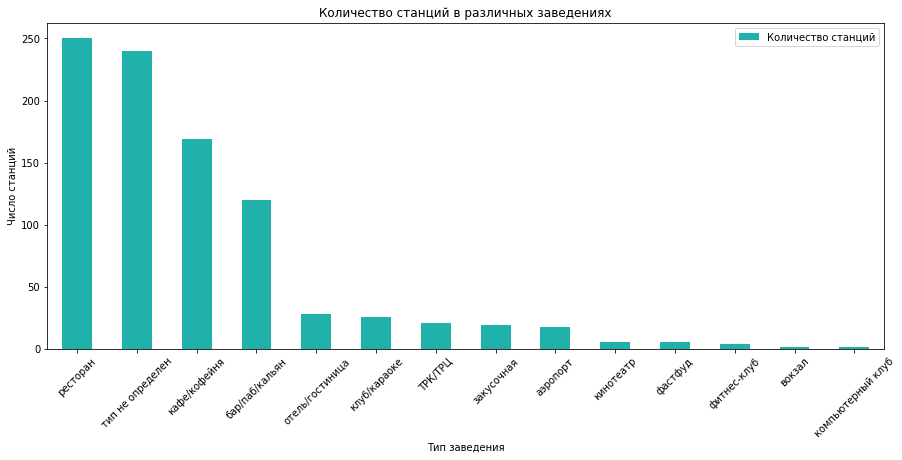

In [70]:
st_in_objects = finished_rents.pivot_table(index='objects_type', values='stationID', aggfunc='nunique').rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
st_in_objects.plot(x='objects_type', 
                          y='station_count', 
                          kind='bar', 
                          title='Количество станций в различных заведениях',
                          label='Количество станций',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Тип заведения')
plt.ylabel('Число станций')
plt.xticks(rotation=45)
plt.show()


На первом месте по числу станций рестораны, на втором — кафе и кофейни, на третьем — бары, пабы и кальянные.

**3.5. Вывод**

lastStation не соответствует реальной ситуации в случае, если станция была отключена.

При соединении данных о месте расположения станций из таблицы station с таблицей rent и данными о последней станции каждого пауэрбанка выяснилось, что во многих случаях данные друг с другом не бьются. Получалось, что пауэрбанк в таблице rent был приписан к одному stationID, стартовая станция обозначена другим ID, а последняя станция — третьим.

На первом месте по числу станций рестораны, на втором — кафе и кофейни, на третьем — бары, пабы и кальянные.

**4. Доходы**

Теперь посмотрим на объем начислений и размер долга по завершившимся арендам.

In [71]:
# посмотрим на представленные в тарифах регионы
finished_rents['location'].unique()

array(['BY', 'RU'], dtype=object)

Часть аренд относится к тарифам, действующим на территории РФ, часть — к тарифам, действующим на территории Беларуси.

Было принято решение разделить датасет на два по региональному признаку, чтобы на этом этапе не искажать данные неточными переводами из одной валюты в другую.

**4.1. Доходы франчайзи на территории России**

Отделим данные об арендах, совершенных по тарифам, действующим на территории РФ.

In [72]:
ru_segment = finished_rents.query('location == "RU"')

debt_ru = ru_segment['debt'].sum().astype('float')
amount_ru = ru_segment['totalAmount'].sum()


print('Сумма начислений по всем завершившимся арендам:', amount_ru)
print('Сумма долга по всем завершившимся арендам:', debt_ru)
print('Сумма начисленной выручки за вычетом долга:', amount_ru - debt_ru)

Сумма начислений по всем завершившимся арендам: 55987288.0
Сумма долга по всем завершившимся арендам: 4093300.0
Сумма начисленной выручки за вычетом долга: 51893988.0


Проверим, бьются ли эти данные с данными из таблицы транзакций.

In [73]:
print(transactions.shape)
display(transactions.head())
print('\033[1m' + 'Информация о датафрейме' + '\033[0m')
print(transactions.info())
print()
print('\033[1m' + 'Количество пропусков' + '\033[0m')
print(transactions.isnull().sum())

(745236, 12)


,_id,createdDate,description,price,rentId,transactionStatus,user._id,user.blocking,user.createdDate,user.roles,user.telegramLoginState,user.webUser
0,5ece363cab9b814d8716a6f1,2020-05-27T09:43:24.327Z,tariff period: 1,0,5ece363cab9b814d8716a6f0,CREDIT,5ece331eab9b814d8716a6ea,False,2020-05-27T09:30:06.148Z,"[{""role"":""USER""}]",False,True
1,5ece45a9ab9b814d8716a704,2020-05-27T10:49:13.373Z,tariff period: 2,50,5ece45a5ab9b814d8716a703,CREDIT,5ece331eab9b814d8716a6ea,False,2020-05-27T09:30:06.148Z,"[{""role"":""USER""}]",False,True
2,5ece45a9ab9b814d8716a705,2020-05-27T10:49:13.374Z,tariff period: 2 credit card: 1377,50,5ece45a5ab9b814d8716a703,DEBIT,5ece331eab9b814d8716a6ea,False,2020-05-27T09:30:06.148Z,"[{""role"":""USER""}]",False,True
3,5ecfd910ab9b815292b21713,2020-05-28T15:30:24.921Z,tariff period: 1,0,5ecfd910ab9b815292b21712,CREDIT,5ece331eab9b814d8716a6ea,False,2020-05-27T09:30:06.148Z,"[{""role"":""USER""}]",False,True
4,5ed7b00bab9b811856f6cab4,2020-06-03T14:13:31.525Z,tariff period: 1,0,5ed7b00bab9b811856f6cab3,CREDIT,5ece331eab9b814d8716a6ea,False,2020-05-27T09:30:06.148Z,"[{""role"":""USER""}]",False,True


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745236 entries, 0 to 745235
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   _id                      745236 non-null  object 
 1   createdDate              745236 non-null  object 
 2   description              745236 non-null  object 
 3   price                    745236 non-null  float64
 4   rentId                   745236 non-null  object 
 5   transactionStatus        745236 non-null  object 
 6   user._id                 745233 non-null  object 
 7   user.blocking            745233 non-null  object 
 8   user.createdDate         745233 non-null  object 
 9   user.roles               745233 non-null  object 
 10  user.telegramLoginState  745233 non-null  object 
 11  user.webUser             745233 non-null  object 
dtypes: float64(1), object(11)
memory usage: 68.2+ MB
None

Количество пропусков
_id           

In [74]:
# приведем типы данных к правильному виду
transactions['createdDate'] = pd.to_datetime(transactions['createdDate'])
transactions['user.createdDate'] = pd.to_datetime(transactions['user.createdDate'])

In [75]:
# добавим к транзакциям данные о регионах тарифов
rents_location = rents[['_id', 'groupTariffs.location']].rename(columns={'_id': 'rentId', 'groupTariffs.location': 'location'})
transactions = pd.merge(transactions, rents_location[['location', 'rentId']], on='rentId', how='left')

In [76]:
transactions['transactionStatus'].unique()

array(['CREDIT', 'DEBIT', 'REFUND'], dtype=object)

CREDIT — сумма, которую пользователь перевел на счет личного кабинета;

DEBIT — сумма, которую пользователь оплатил по истечении времени аренды;

REFUND — возврат денежных средств пользователю.

У нас имеются возвраты, которые необходимо учесть.

In [77]:
# сумма кредитов ру сегмента
transactions_ru_credit = transactions.query('transactionStatus == "CREDIT" and location == "RU"')
credit_ru_sum = transactions_ru_credit['price'].sum().astype('float')

# считаем сумму ру возвратов
transactions_ru_refund = transactions.query('transactionStatus == "REFUND" and location == "RU"')
refund_ru_sum = transactions_ru_refund['price'].sum().astype('float')

# считаем сумму ру оплат
transactions_ru_payment = transactions.query('transactionStatus == "DEBIT" and location == "RU"')
payment_ru_sum = transactions_ru_payment['price'].sum().astype('float')

In [78]:
print('Сумма начислений по всем завершившимся арендам по таблице rent:', amount_ru)
print('Сумма начислений по таблице transactions:', credit_ru_sum)
print('Сумма долга по всем завершившимся арендам:', debt_ru)
print()
print('Сумма начислений по таблице rent за вычетом долга:', amount_ru - debt_ru)
print('Сумма фактической выручки:', payment_ru_sum + credit_ru_sum - refund_ru_sum)

Сумма начислений по всем завершившимся арендам по таблице rent: 55987288.0
Сумма начислений по таблице transactions: 35161199.0
Сумма долга по всем завершившимся арендам: 4093300.0

Сумма начислений по таблице rent за вычетом долга: 51893988.0
Сумма фактической выручки: 59277655.0


**Сумма начислений отличается в таблице *rent* и таблице *transactions*.**

Посмотрим, к каким станциям имеют отношение эти транзакции.

**4.1.1. Анализ станций по окупаемости**

In [79]:
# отберем записи 
ru_debit_refund_transactions = transactions.query('location == "RU"')

stations_debit_refund = pd.merge(ru_debit_refund_transactions, finished_rents[['stationID', 'numberSlots', 'powerBankID', 'objects_type', 'rentId']], on='rentId', how='left')
stations_debit_refund = stations_debit_refund.drop_duplicates().reset_index(drop=True)

In [80]:
stations_debit_refund

,_id,createdDate,description,price,rentId,transactionStatus,user._id,user.blocking,user.createdDate,user.roles,user.telegramLoginState,user.webUser,location,stationID,numberSlots,powerBankID,objects_type
0,5ece363cab9b814d8716a6f1,2020-05-27 09:43:24.327000+00:00,tariff period: 1,0,5ece363cab9b814d8716a6f0,CREDIT,5ece331eab9b814d8716a6ea,False,2020-05-27 09:30:06.148000+00:00,"[{""role"":""USER""}]",False,True,RU,NaN,NaN,NaN,NaN
1,5ece45a9ab9b814d8716a704,2020-05-27 10:49:13.373000+00:00,tariff period: 2,50,5ece45a5ab9b814d8716a703,CREDIT,5ece331eab9b814d8716a6ea,False,2020-05-27 09:30:06.148000+00:00,"[{""role"":""USER""}]",False,True,RU,NaN,NaN,NaN,NaN
2,5ece45a9ab9b814d8716a705,2020-05-27 10:49:13.374000+00:00,tariff period: 2 credit card: 1377,50,5ece45a5ab9b814d8716a703,DEBIT,5ece331eab9b814d8716a6ea,False,2020-05-27 09:30:06.148000+00:00,"[{""role"":""USER""}]",False,True,RU,NaN,NaN,NaN,NaN
3,5ecfd910ab9b815292b21713,2020-05-28 15:30:24.921000+00:00,tariff period: 1,0,5ecfd910ab9b815292b21712,CREDIT,5ece331eab9b814d8716a6ea,False,2020-05-27 09:30:06.148000+00:00,"[{""role"":""USER""}]",False,True,RU,NaN,NaN,NaN,NaN
4,5ed7b00bab9b811856f6cab4,2020-06-03 14:13:31.525000+00:00,tariff period: 1,0,5ed7b00bab9b811856f6cab3,CREDIT,5ece331eab9b814d8716a6ea,False,2020-05-27 09:30:06.148000+00:00,"[{""role"":""USER""}]",False,True,RU,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933954,63737c4065c92736f6b050b6,2022-11-15 11:47:12.181000+00:00,tariff period: 1 credit card: 0192,0,635fb5ba4912f54cf24b09d2,DEBIT,635fb53c4912f54cf24b0980,False,2022-10-31 11:45:00.387000+00:00,"[{""role"":""USER""}]",False,True,RU,NaN,NaN,NaN,NaN
933955,63737c5c65c92736f6b050c9,2022-11-15 11:47:40.594000+00:00,tariff period: 1,50,63737c5665c92736f6b050c2,CREDIT,63737c1c65c92736f6b050a0,False,2022-11-15 11:46:36.193000+00:00,"[{""role"":""USER""}]",False,True,RU,FFRH082107800062,8,5063825300585972736,кафе/кофейня
933956,63737c5c65c92736f6b050ca,2022-11-15 11:47:40.603000+00:00,tariff period: 1 credit card: 6810,50,63737c5665c92736f6b050c2,DEBIT,63737c1c65c92736f6b050a0,False,2022-11-15 11:46:36.193000+00:00,"[{""role"":""USER""}]",False,True,RU,FFRH082107800062,8,5063825300585972736,кафе/кофейня
933957,63737cb765c92736f6b050f4,2022-11-15 11:49:11.626000+00:00,tariff period: 1,100,635fb6604912f54cf24b0a4e,CREDIT,635fb5c54912f54cf24b09dd,False,2022-10-31 11:47:17.886000+00:00,"[{""role"":""USER""}]",False,True,RU,NaN,NaN,NaN,NaN


In [81]:
'Доля неопределенных станций составляет: {:.0%}'.format(stations_debit_refund['stationID'].isna().sum() / len(stations_debit_refund['stationID']))

'Доля неопределенных станций составляет: 25%'

Четверть станций неопределены, так как мы ориентировались только на закончившиеся аренды. Значит 25% транзакций принадлежит клиентам, еще не вернувшим пауэрбанк.

In [82]:
stations_debit_refund = stations_debit_refund.dropna(subset=['stationID'])
stations_debit_refund.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700042 entries, 26627 to 933956
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   _id                      700042 non-null  object             
 1   createdDate              700042 non-null  datetime64[ns, UTC]
 2   description              700042 non-null  object             
 3   price                    700042 non-null  float64            
 4   rentId                   700042 non-null  object             
 5   transactionStatus        700042 non-null  object             
 6   user._id                 700042 non-null  object             
 7   user.blocking            700042 non-null  object             
 8   user.createdDate         700042 non-null  datetime64[ns, UTC]
 9   user.roles               700042 non-null  object             
 10  user.telegramLoginState  700042 non-null  object             
 11  user.webU

Добавим статус для станций, если он известен.

In [83]:
stations_debit_refund = pd.merge(stations_debit_refund, stations[['stationID', 'status']], on='stationID', how='left')
stations_debit_refund = stations_debit_refund.drop_duplicates().reset_index(drop=True)
stations_debit_refund['price'] = stations_debit_refund['price'].astype('int')
stations_debit_refund.head(3)

,_id,createdDate,description,price,rentId,transactionStatus,user._id,user.blocking,user.createdDate,user.roles,user.telegramLoginState,user.webUser,location,stationID,numberSlots,powerBankID,objects_type,status
0,6035bf3c3319a87889d5957d,2021-02-24 02:51:40.618000+00:00,tariff period: 2,50,6035bf373319a87889d5957b,CREDIT,600bae882b7cb87dc9881a37,False,2021-01-23 05:05:12.473000+00:00,"[{""role"":""USER""}]",False,True,RU,FFRH082006200022,8,5930171193822807040,отель/гостиница,CONNECTED
1,6035bf3c3319a87889d5957e,2021-02-24 02:51:40.619000+00:00,tariff period: 2 credit card: 3633,50,6035bf373319a87889d5957b,DEBIT,600bae882b7cb87dc9881a37,False,2021-01-23 05:05:12.473000+00:00,"[{""role"":""USER""}]",False,True,RU,FFRH082006200022,8,5930171193822807040,отель/гостиница,CONNECTED
2,603b8b763d18b03b58d8b201,2021-02-28 12:24:22.954000+00:00,tariff period: 1,100,603b8b6f3d18b03b58d8b1ff,CREDIT,603a81fc3d18b03b58d8af84,False,2021-02-27 17:31:40.311000+00:00,"[{""role"":""USER""}]",False,True,RU,FFRH082001490048,8,5930171193822807040,тип не определен,CONNECTED


In [84]:
print('Количество записей в датасете:', len(stations_debit_refund))
print('Число возвратов:', len(stations_debit_refund.query('transactionStatus == "REFUND"')))

Количество записей в датасете: 700042
Число возвратов: 77


Процент возвратов совсем небольшой, но мы все-таки исключим их из набора данных для оценки размера поступлений.

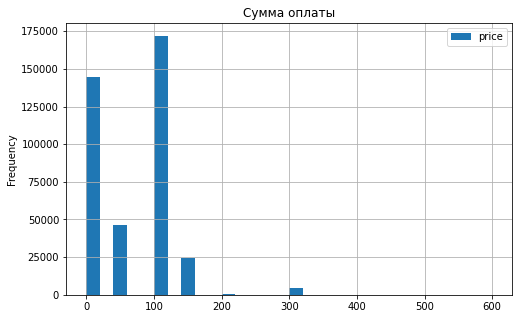

count   393496
mean        67
std        160
min          0
25%          0
50%        100
75%        100
max      14300
Name: price, dtype: float64

In [85]:
# отбираем только фактические оплаты
ru_stations_debit = stations_debit_refund.query('transactionStatus == "DEBIT"')

ru_stations_debit.plot(y='price', kind='hist', bins=30, grid=True, title='Сумма оплаты', figsize=(8,5), range=(0,600))
plt.show()
ru_stations_debit['price'].describe()

В 75% случаев размер оплаты составляет 100 руб., максимальное значение 14 300 руб.

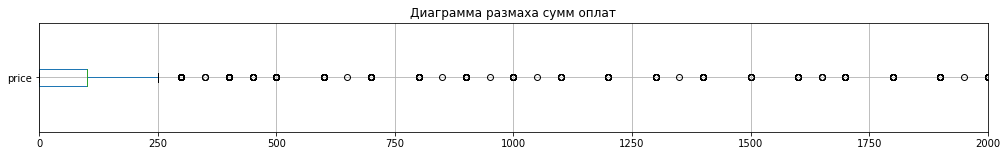

In [86]:
fig, ax = plt.subplots(figsize = (17,2))
ax = ru_stations_debit[['price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха сумм оплат');
ax.set_xlim(0, 2000);

Верхняя граница основной выборки находится на уровне 250 руб. Выбросы наиболее плотно распредлены до значения 500 руб.

Таким образом, мы можем отсечь все оплаты выше 500 руб., чтобы посмотреть наиболее стандартные станции, и отдельно можно изучить те, что получают более крупные оплаты. Возможно, их местоположение сможет нам что-то подсказать.

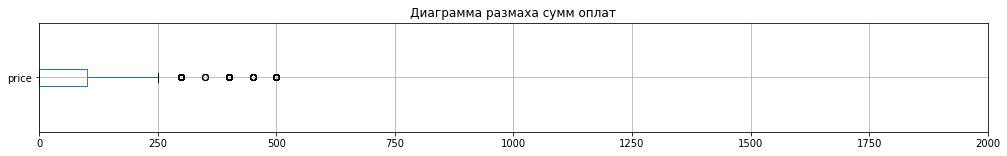

In [87]:
ru_stations_debit_spread = ru_stations_debit.query('price <= 500')

fig, ax = plt.subplots(figsize = (17,2))
ax = ru_stations_debit_spread[['price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха сумм оплат');
ax.set_xlim(0, 2000);

Теперь посмотрим, какие станции принесли больше всего денег на территории РФ по имеющимся у нас данным чуть больше чем за два с половиной года (с 27 мая 2020 года по 15 ноября 2022 года).

In [88]:
ru_stations_revenue = ru_stations_debit_spread.groupby('stationID')[['price']].sum().sort_values(by='price', ascending=False).reset_index()

ru_stations_refund = stations_debit_refund.query('transactionStatus == "REFUND"').groupby('stationID')[['price']].sum().sort_values(by='price', ascending=False).reset_index()

ru_stations_revenue = ru_stations_revenue.merge(ru_stations_refund, on='stationID', how='left').rename(columns={'price_x': 'payment_sum', 'price_y': 'debt_sum'})
ru_stations_revenue = ru_stations_revenue.drop_duplicates().reset_index(drop=True)
ru_stations_revenue['debt_sum'] = ru_stations_revenue['debt_sum'].fillna(0)
# сразу учтем 25%, которые отойдут компании
ru_stations_revenue['revenue'] = (ru_stations_revenue['payment_sum'] - ru_stations_revenue['debt_sum']) - ((ru_stations_revenue['payment_sum'] - ru_stations_revenue['debt_sum']) / 100 * 25)
ru_stations_revenue.head(3)

,stationID,payment_sum,debt_sum,revenue
0,FFRH082006890045,1003800,600,752400
1,FFRH082001660045,1003800,600,752400
2,FFRH082001650037,1003800,600,752400


In [89]:
# добавим дату первой аренды для каждой станции
ru_st_avg_revenue_per_month = ru_stations_revenue
ru_st_avg_revenue_per_month = pd.merge(ru_st_avg_revenue_per_month, rents[['startDate', 'stationID']], on='stationID', how='left')
ru_st_avg_revenue_per_month = ru_st_avg_revenue_per_month.drop_duplicates(subset=['stationID'], keep='first').reset_index(drop=True)
ru_st_avg_revenue_per_month.head(3)

,stationID,payment_sum,debt_sum,revenue,startDate
0,FFRH082006890045,1003800,600,752400,2020-08-16 08:25:27.509000+00:00
1,FFRH082001660045,1003800,600,752400,2021-03-09 17:21:48.918000+00:00
2,FFRH082001650037,1003800,600,752400,2021-03-09 14:21:23.259000+00:00


In [90]:
ru_st_avg_revenue_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   stationID    799 non-null    object             
 1   payment_sum  799 non-null    int64              
 2   debt_sum     799 non-null    float64            
 3   revenue      799 non-null    float64            
 4   startDate    796 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(1)
memory usage: 31.3+ KB


In [91]:
# уберем три пропуска
ru_st_avg_revenue_per_month = ru_st_avg_revenue_per_month.dropna()

In [92]:
ru_st_avg_revenue_per_month['startDate'] = ru_st_avg_revenue_per_month['startDate'].dt.date
ru_st_avg_revenue_per_month

,stationID,payment_sum,debt_sum,revenue,startDate
0,FFRH082006890045,1003800,600,752400,2020-08-16
1,FFRH082001660045,1003800,600,752400,2021-03-09
2,FFRH082001650037,1003800,600,752400,2021-03-09
3,FFRH082107010096,682950,0,512212,2021-09-21
4,RL3H242001840013,682950,0,512212,2021-02-10
...,...,...,...,...,...
793,FFRH082001860047,100,0,75,2021-11-10
794,FFRH042012650066,100,0,75,2021-05-14
795,FFRH042108200300,50,0,38,2022-02-23
796,FFRH042012200018,50,0,38,2021-09-10


**Активные и отключенные станции**

Добавим статус станций, чтобы видеть уже не действующие.

In [93]:
ru_st_avg_revenue_per_month = pd.merge(ru_st_avg_revenue_per_month, stations[['status', 'stationID']], on='stationID', how='left')
ru_st_avg_revenue_per_month = ru_st_avg_revenue_per_month[['stationID', 'status', 'startDate', 'payment_sum', 'debt_sum', 'revenue']]
ru_st_avg_revenue_per_month.head(3)

,stationID,status,startDate,payment_sum,debt_sum,revenue
0,FFRH082006890045,CONNECTED,2020-08-16,1003800,600,752400
1,FFRH082001660045,CONNECTED,2021-03-09,1003800,600,752400
2,FFRH082001650037,CONNECTED,2021-03-09,1003800,600,752400


Посмотрим, как много отключенных станций и станций с неизвестным статусом в российском сегменте.

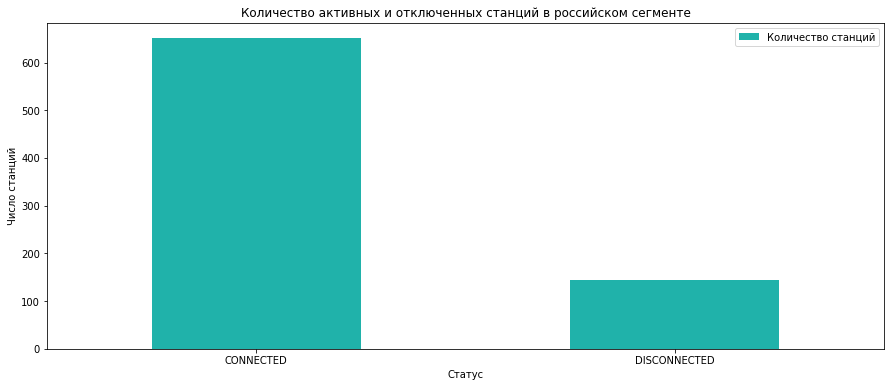

,status,station_count,percentage
0,CONNECTED,651,82
1,DISCONNECTED,145,18


Общее число станций:  796
Число станций с неизвестным статусом:  0


In [94]:
disc_ru_stations = ru_st_avg_revenue_per_month.pivot_table(index='status', values='stationID', aggfunc='nunique')
disc_ru_stations = disc_ru_stations.rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
disc_ru_stations.plot(x='status', 
                          y='station_count', 
                          kind='bar', 
                          title='Количество активных и отключенных станций в российском сегменте',
                          label='Количество станций',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Статус')
plt.ylabel('Число станций')
plt.xticks(rotation=0)
plt.show()


disc_ru_stations['percentage'] = round(((disc_ru_stations['station_count'] / disc_ru_stations['station_count'].sum())*100), 2)
display(disc_ru_stations)
print('Общее число станций: ', disc_ru_stations['station_count'].sum())
print('Число станций с неизвестным статусом: ', ru_st_avg_revenue_per_month['status'].isna().sum())

145 станций уже отключены по имеющимся на текущий момент данным. Для корректности расчетов используем в качестве последней дату установки статуса 'DISCONNECT'.

In [95]:
ru_st_avg_revenue_per_month = pd.merge(ru_st_avg_revenue_per_month, stations[['statusAt', 'stationID']], on='stationID', how='left')
ru_st_avg_revenue_per_month['statusAt'] = ru_st_avg_revenue_per_month['statusAt'].dt.date
ru_st_avg_revenue_per_month.insert(3, 'finishDate', ru_st_avg_revenue_per_month['statusAt'])
ru_st_avg_revenue_per_month = ru_st_avg_revenue_per_month.drop('statusAt', axis=1)
ru_st_avg_revenue_per_month.head(3)

,stationID,status,startDate,finishDate,payment_sum,debt_sum,revenue
0,FFRH082006890045,CONNECTED,2020-08-16,2022-11-15,1003800,600,752400
1,FFRH082001660045,CONNECTED,2021-03-09,2022-11-15,1003800,600,752400
2,FFRH082001650037,CONNECTED,2021-03-09,2022-11-15,1003800,600,752400


In [96]:
# рассчитаем, сколько месяцев просуществовала каждая станция
ru_st_avg_revenue_per_month['finishDate'] = ru_st_avg_revenue_per_month['finishDate'].fillna(ru_st_avg_revenue_per_month.loc[0, "finishDate"])
ru_st_avg_revenue_per_month['months'] = ((ru_st_avg_revenue_per_month.finishDate - ru_st_avg_revenue_per_month.startDate)/np.timedelta64(1, 'M'))
ru_st_avg_revenue_per_month = ru_st_avg_revenue_per_month[['stationID', 'status', 'startDate', 'finishDate', 'months', 'payment_sum', 'debt_sum', 'revenue']]

In [97]:
# рассчитаем средний доход в месяц
ru_st_avg_revenue_per_month['revenue_per_month'] = ru_st_avg_revenue_per_month['revenue'] / ru_st_avg_revenue_per_month['months']

In [98]:
# добавим дополнительные столбцы: инфу о типе объекта и количество слотов станции
ru_st_avg_revenue_per_month = pd.merge(ru_st_avg_revenue_per_month, stations[['stationID', 'objects_type', 'numberSlots']], on='stationID', how='left')
ru_st_avg_revenue_per_month.head()

,stationID,status,startDate,finishDate,months,payment_sum,debt_sum,revenue,revenue_per_month,objects_type,numberSlots
0,FFRH082006890045,CONNECTED,2020-08-16,2022-11-15,27,1003800,600,752400,27894,ресторан,8
1,FFRH082001660045,CONNECTED,2021-03-09,2022-11-15,20,1003800,600,752400,37176,тип не определен,8
2,FFRH082001650037,CONNECTED,2021-03-09,2022-11-15,20,1003800,600,752400,37176,закусочная,8
3,FFRH082107010096,CONNECTED,2021-09-21,2022-11-15,14,682950,0,512212,37119,аэропорт,8
4,RL3H242001840013,CONNECTED,2021-02-10,2022-11-15,21,682950,0,512212,24246,аэропорт,24


Теперь изучим, сколько слотов обычно у станций.

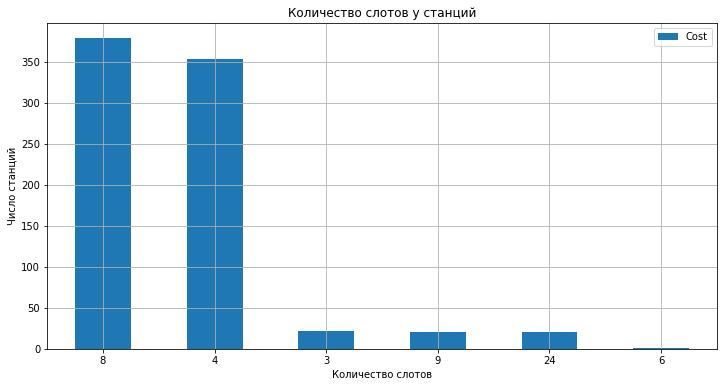

Число станций с неизвестным количеством слотов:  0


In [99]:
(
    ru_st_avg_revenue_per_month.groupby('numberSlots')['stationID'].count().reset_index().sort_values('stationID', ascending=False).plot(
        x='numberSlots',
        y='stationID',
        grid=True,
        figsize=(12,6),
        style='o-',
        kind='bar',
        label='Cost',
        # color=['#355C7D', '#C06C84', '#F67280', '#F8B195'],
        # alpha=0.7
)
)

plt.xlabel("Количество слотов")
plt.ylabel('Число станций')
plt.title("Количество слотов у станций")
plt.xticks(rotation=0)
plt.show()

print('Число станций с неизвестным количеством слотов: ', ru_st_avg_revenue_per_month['numberSlots'].isna().sum())

В соответствии с найденными в интернете данными, стоимость установки станции для франчайзи составляет:

4 слота — 18 000 руб.

6 слотов — 26 000 руб.

8 слотов — 36 000 руб.

24 слота — 180 000 руб.

Опираясь на указанные цены, будем считать, что для станций с 9-ю слотами стоимость установки составит 40 500 руб., а для станций с 3-мя слотами — 13 500 руб.

Дополним таблицу этими данными.

In [100]:
def installationCost(value):
  if value == 3:
    return 13500
  if value == 4:
    return 18000
  if value == 6:
    return 26000
  if value == 8:
    return 36000
  if value == 9:
    return 40500
  if value == 24:
    return 180000

In [101]:
ru_st_avg_revenue_per_month['installation_cost'] = ru_st_avg_revenue_per_month['numberSlots'].apply(installationCost)
ru_st_avg_revenue_per_month.head()

,stationID,status,startDate,finishDate,months,payment_sum,debt_sum,revenue,revenue_per_month,objects_type,numberSlots,installation_cost
0,FFRH082006890045,CONNECTED,2020-08-16,2022-11-15,27,1003800,600,752400,27894,ресторан,8,36000
1,FFRH082001660045,CONNECTED,2021-03-09,2022-11-15,20,1003800,600,752400,37176,тип не определен,8,36000
2,FFRH082001650037,CONNECTED,2021-03-09,2022-11-15,20,1003800,600,752400,37176,закусочная,8,36000
3,FFRH082107010096,CONNECTED,2021-09-21,2022-11-15,14,682950,0,512212,37119,аэропорт,8,36000
4,RL3H242001840013,CONNECTED,2021-02-10,2022-11-15,21,682950,0,512212,24246,аэропорт,24,180000


In [102]:
ru_st_avg_revenue_per_month['installation_cost'] = ru_st_avg_revenue_per_month['installation_cost'].fillna(0)

In [103]:
ru_st_avg_revenue_per_month[['revenue_per_month', 'revenue', 'installation_cost', 'months']] = ru_st_avg_revenue_per_month[['revenue_per_month', 'revenue', 'installation_cost', 'months']].astype('int')

In [104]:
ru_st_avg_revenue_per_month['payback_month'] = round(ru_st_avg_revenue_per_month['installation_cost'] / ru_st_avg_revenue_per_month['revenue_per_month'])
# заменим значения бесконечности на 0
ru_st_avg_revenue_per_month.replace([np.inf, -np.inf], 0, inplace=True)
ru_st_avg_revenue_per_month['payback_month'] = ru_st_avg_revenue_per_month['payback_month'].astype('int')
ru_st_avg_revenue_per_month['payback_month'] = ru_st_avg_revenue_per_month['payback_month'] + 1
ru_st_avg_revenue_per_month.head()

,stationID,status,startDate,finishDate,months,payment_sum,debt_sum,revenue,revenue_per_month,objects_type,numberSlots,installation_cost,payback_month
0,FFRH082006890045,CONNECTED,2020-08-16,2022-11-15,26,1003800,600,752400,27893,ресторан,8,36000,2
1,FFRH082001660045,CONNECTED,2021-03-09,2022-11-15,20,1003800,600,752400,37176,тип не определен,8,36000,2
2,FFRH082001650037,CONNECTED,2021-03-09,2022-11-15,20,1003800,600,752400,37176,закусочная,8,36000,2
3,FFRH082107010096,CONNECTED,2021-09-21,2022-11-15,13,682950,0,512212,37119,аэропорт,8,36000,2
4,RL3H242001840013,CONNECTED,2021-02-10,2022-11-15,21,682950,0,512212,24245,аэропорт,24,180000,8


Добавим категории refund и not refund, чтобы сразу видеть уже окупились или еще нет станции.

In [105]:
ru_st_avg_revenue_per_month['income'] = ru_st_avg_revenue_per_month['revenue'] - ru_st_avg_revenue_per_month['installation_cost']

In [106]:
# функция для присвоения категории
def paybackStatus(value):
  if value >= 0:
    return 'refunded'
  if value < 0:
    return 'not refunded'

In [107]:
ru_st_avg_revenue_per_month['refunded'] = ru_st_avg_revenue_per_month['income'].apply(paybackStatus)
ru_st_avg_revenue_per_month = ru_st_avg_revenue_per_month.drop('income', axis=1)
ru_st_avg_revenue_per_month.head()

,stationID,status,startDate,finishDate,months,payment_sum,debt_sum,revenue,revenue_per_month,objects_type,numberSlots,installation_cost,payback_month,refunded
0,FFRH082006890045,CONNECTED,2020-08-16,2022-11-15,26,1003800,600,752400,27893,ресторан,8,36000,2,refunded
1,FFRH082001660045,CONNECTED,2021-03-09,2022-11-15,20,1003800,600,752400,37176,тип не определен,8,36000,2,refunded
2,FFRH082001650037,CONNECTED,2021-03-09,2022-11-15,20,1003800,600,752400,37176,закусочная,8,36000,2,refunded
3,FFRH082107010096,CONNECTED,2021-09-21,2022-11-15,13,682950,0,512212,37119,аэропорт,8,36000,2,refunded
4,RL3H242001840013,CONNECTED,2021-02-10,2022-11-15,21,682950,0,512212,24245,аэропорт,24,180000,8,refunded


In [108]:
ru_st_avg_revenue_per_month['payback_month'].describe()

count     796
mean      276
std      1047
min         1
25%        21
50%        44
75%       136
max     18001
Name: payback_month, dtype: float64

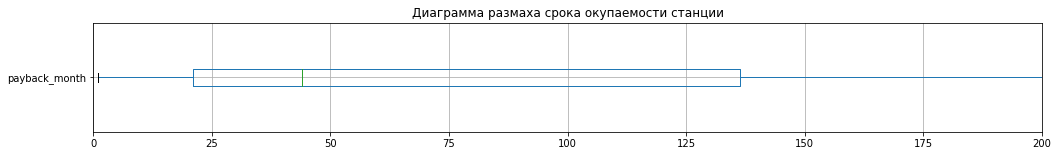

In [109]:
fig, ax = plt.subplots(figsize = (17,2))
ax = ru_st_avg_revenue_per_month[['payback_month']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха срока окупаемости станции');
ax.set_xlim(0, 200);

Медианное значение окупаемости по всем станциям — 44 месяца. Данные могут быть искажены наличием отключенных станций и станций без статуса. Уберем их и посмотрим на результат еще раз.

In [110]:
ru_st_avg_revenue_per_month.query('status == "CONNECTED"')['payback_month'].describe()

count     651
mean      246
std      1100
min         2
25%        20
50%        39
75%       110
max     18001
Name: payback_month, dtype: float64

Теперь медианное значение периода окупаемости для активных на данный момент станций — 39 месяцев.

Для наглядности посмотрим на станции, которые работают уже три месяца, а значит должны приближаться к точке окупаемости.

In [111]:
ru_st_avg_revenue_per_month.query('status == "CONNECTED" and months == 3')

,stationID,status,startDate,finishDate,months,payment_sum,debt_sum,revenue,revenue_per_month,objects_type,numberSlots,installation_cost,payback_month,refunded
409,FFRH082111080036,CONNECTED,2022-08-01,2022-11-15,3,9300,0,6975,2002,кафе/кофейня,8,36000,19,not refunded
417,FFRH042108660294,CONNECTED,2022-07-22,2022-11-15,3,9200,0,6900,1810,тип не определен,4,18000,11,not refunded
640,FFRH042108660104,CONNECTED,2022-07-24,2022-11-15,3,2000,0,1500,400,ресторан,4,18000,46,not refunded
668,FFRH042108620270,CONNECTED,2022-07-30,2022-11-15,3,1400,0,1050,295,клуб/караоке,4,18000,62,not refunded
734,FFRH042108810165,CONNECTED,2022-07-29,2022-11-15,3,500,0,375,104,кафе/кофейня,4,18000,174,not refunded


Прогнозируемый месяц окупаемости для всех имеющихся точек далёк. При таком несоответствии реальности и ожидания эти точки — кандидаты на отключение.

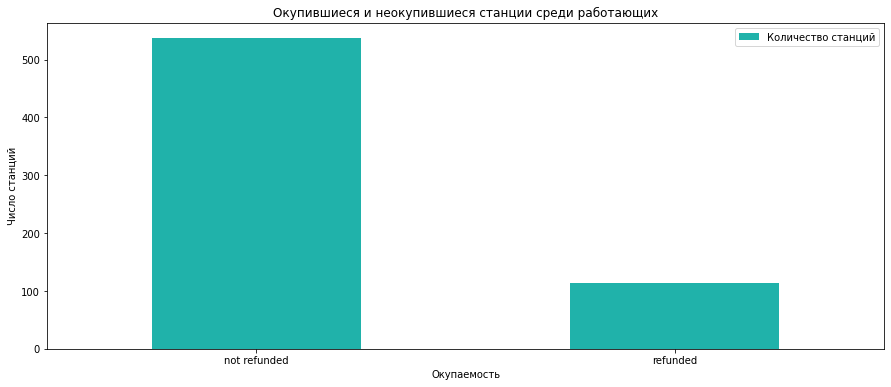

,refunded,station_count,percentage
0,not refunded,537,82
1,refunded,114,18


Сумма станций:  651
Общее число активных станций:  651


In [112]:
connect = ru_st_avg_revenue_per_month.query('status == "CONNECTED"')
connect_ref = connect.pivot_table(index='refunded', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
connect_ref.plot(
    x='refunded',
    y='station_count',
    kind='bar',
    title='Окупившиеся и неокупившиеся станции среди работающих',
    label='Количество станций',
    figsize=(15,6),
    color='lightseagreen'
)
plt.xlabel('Окупаемость')
plt.ylabel('Число станций')
plt.xticks(rotation=0)
plt.show()


connect_ref['percentage'] = round(((connect_ref['station_count'] / connect_ref['station_count'].sum())*100), 2)
display(connect_ref)
print('Сумма станций: ', connect_ref['station_count'].sum())
print('Общее число активных станций: ', ru_st_avg_revenue_per_month.query('status == "CONNECTED"')['stationID'].count())

82% станций все еще не окупились.

Сравним с отключенными станциями.

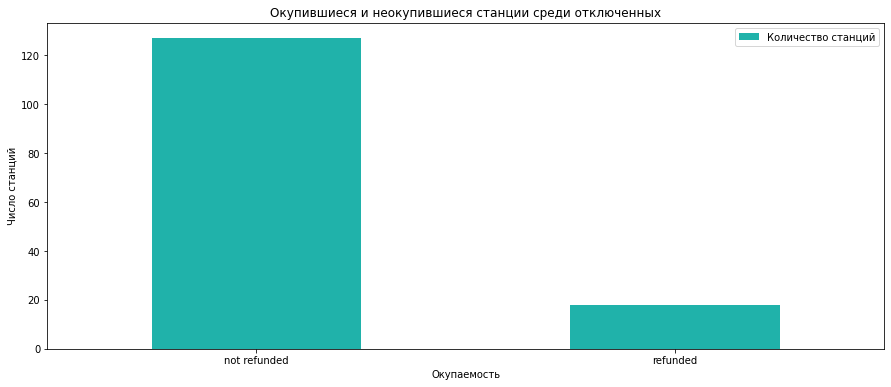

,refunded,station_count,percentage
0,not refunded,127,88
1,refunded,18,12


Сумма станций:  145
Общее число неактивных станций:  145


In [113]:
disconnect = ru_st_avg_revenue_per_month.query('status == "DISCONNECTED"')
disc_ref = disconnect.pivot_table(index='refunded', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
disc_ref.plot(
    x='refunded',
    y='station_count',
    kind='bar',
    title='Окупившиеся и неокупившиеся станции среди отключенных',
    label='Количество станций',
    figsize=(15,6),
    color='lightseagreen'
)
plt.xlabel('Окупаемость')
plt.ylabel('Число станций')
plt.xticks(rotation=0)
plt.show()


disc_ref['percentage'] = round(((disc_ref['station_count'] / disc_ref['station_count'].sum())*100), 2)
display(disc_ref)
print('Сумма станций: ', disc_ref['station_count'].sum())
print('Общее число неактивных станций: ', ru_st_avg_revenue_per_month.query('status == "DISCONNECTED"')['stationID'].count())

88% отключенных станций так и не дошли до точки окупаемости, но есть и 12% окупившихся, которые тем не менее отключили.

Возможно, на окупаемость они выходили слишком долго и как только затраты на установку отбились, было решено отказаться от станции. На решение в таких случаях могло повлиять сложности в обслуживании станции.

Оценим, как долго работают уже все еще не окупившиеся, но пока активные станции.

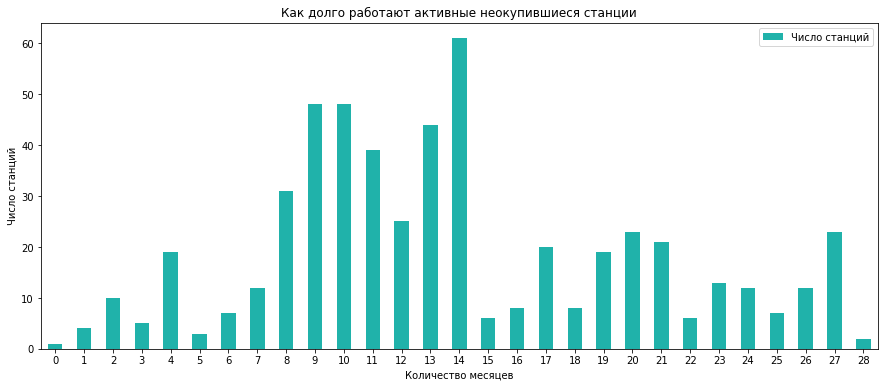

Сумма станций:  537
Общее число активных не окупившихся станций:  537


In [114]:
connect_ref = connect.query('refunded == "not refunded"').pivot_table(index='months', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='months').reset_index()

# построим гистограмму
connect_ref.plot(
    x='months',
    y='station_count',
    kind='bar',
    title='Как долго работают активные неокупившиеся станции',
    label='Число станций',
    figsize=(15,6),
    color='lightseagreen'
)
plt.xlabel('Количество месяцев')
plt.ylabel('Число станций')
plt.xticks(rotation=0)
plt.show()


connect_ref['percentage'] = round(((connect_ref['station_count'] / connect_ref['station_count'].sum())*100), 2)
print('Сумма станций: ', connect_ref['station_count'].sum())
print('Общее число активных не окупившихся станций: ', connect.query('refunded == "not refunded"')['stationID'].count())

Больше всего неокупившихся станций на 14-м месяце, после чего происходит резкое падение числа станций. Таких "просадок" по числу станций еще несколько: на 5-м месяце, на 12-м и 18-м.

Они либо отключаются, либо наконец выходят на окупаемость.

Посмотрим на срок жизни уже отключенных станций, чтобы лучше понять, когда франчайзи отказываются от использования станций.

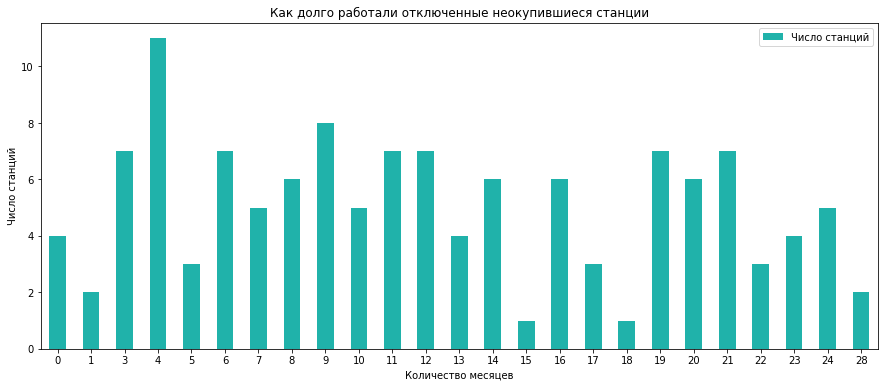

Общее число станций:  127


In [115]:
disc_ref = disconnect.query('refunded == "not refunded"').pivot_table(index='months', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='months').reset_index()

# построим гистограмму
disc_ref.plot(
    x='months',
    y='station_count',
    kind='bar',
    title='Как долго работали отключенные неокупившиеся станции',
    label='Число станций',
    figsize=(15,6),
    color='lightseagreen'
)
plt.xlabel('Количество месяцев')
plt.ylabel('Число станций')
plt.xticks(rotation=0)
plt.show()


disc_ref['percentage'] = round(((disc_ref['station_count'] / disc_ref['station_count'].sum())*100), 2)
print('Общее число станций: ', disc_ref['station_count'].sum())

Можем сделать вывод, что пик отключений происходит после 4-го месяца, когда не получается выйти на ожидаемую окупаемость, что соответствует первому "провалу" на графике активных неокупившихся станций. Также мы можем отметить те станции, которые не просуществовали и месяца, а также бывшие активными 3 месяца. В обоих случаях франчайзи, скорее всего, получали крайне низкие доходы и быстро отказались от станции.

Многие станции отключаются на 15-м и 18-м месяца, что соответствует "провалам" на графике активных станций.

In [116]:
disconnect.query('months == 0')

,stationID,status,startDate,finishDate,months,payment_sum,debt_sum,revenue,revenue_per_month,objects_type,numberSlots,installation_cost,payback_month,refunded
713,FFRH042108650213,DISCONNECTED,2022-10-27,2022-11-14,0,800,0,600,1014,тип не определен,4,18000,19,not refunded
732,FFRT062209250001,DISCONNECTED,2022-10-18,2022-11-08,0,516,0,387,560,тип не определен,6,26000,47,not refunded
747,FFRH082107010087,DISCONNECTED,2021-08-27,2021-09-18,0,400,0,300,415,кафе/кофейня,8,36000,88,not refunded
785,FFRH042108800191,DISCONNECTED,2021-12-04,2021-12-08,0,100,0,75,570,тип не определен,4,18000,33,not refunded


Посмотрев на станции, простоявшие менее месяца, мы не можем сказать, что все они пользовались тест-драйвом. Мы не знаем, когда появилась эта услуга, поэтому можем лишь предположить по срокам пользования. Только одна станция была активна в рамках возможного тест-драйва (14 дней), остальные работали дольше.

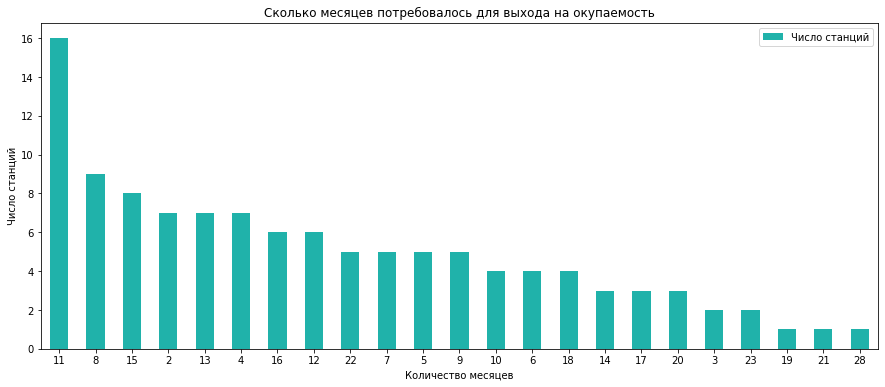

Сумма станций:  114
Общее число окупившихся станций:  114


In [117]:
payback_ref = connect.query('refunded == "refunded"').pivot_table(index='payback_month', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
payback_ref.plot(
    x='payback_month',
    y='station_count',
    kind='bar',
    title='Сколько месяцев потребовалось для выхода на окупаемость',
    label='Число станций',
    figsize=(15,6),
    color='lightseagreen'
)
plt.xlabel('Количество месяцев')
plt.ylabel('Число станций')
plt.xticks(rotation=0)
plt.show()


payback_ref['percentage'] = round(((payback_ref['station_count'] / payback_ref['station_count'].sum())*100), 2)
print('Сумма станций: ', payback_ref['station_count'].sum())
print('Общее число окупившихся станций: ', connect.query('refunded == "refunded"')['stationID'].count())

In [118]:
payback_ref['payback_month'].describe()

count   23
mean    13
std      7
min      2
25%      8
50%     13
75%     18
max     28
Name: payback_month, dtype: float64

Большинству до сих пор работающих станций потребовалось 11 месяцев для выхода на окупаемость.

Медианное значение — 13 месяцев, что соответствует виденному на графике срока "жизни" уже отключенных станций: если станция получала какой-то доход (о чем свидетельствует тот факт, что ее не отключили раньше), но так и не окупилась, на 14-й месяц станция будет отключена.

Посмотрим, в заведениях какого типа расположены или были расположены активные и отключенные станции — окупившиеся и нет.

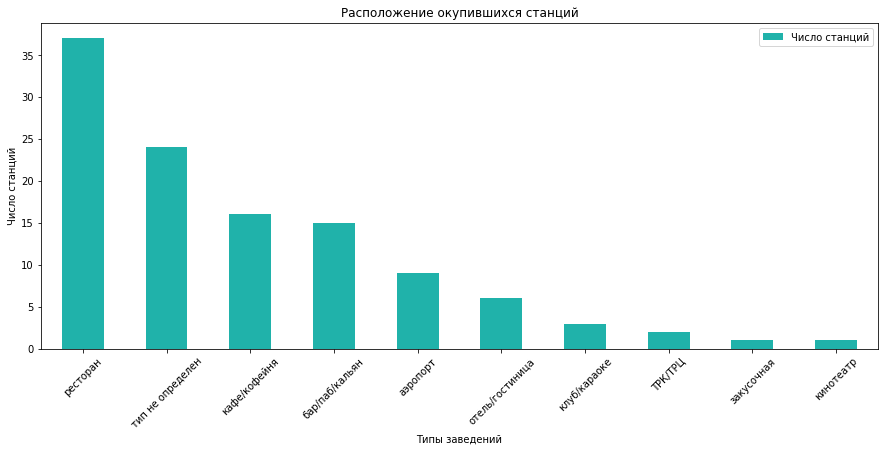

,objects_type,station_count,percentage
0,ресторан,37,32
1,тип не определен,24,21
2,кафе/кофейня,16,14
3,бар/паб/кальян,15,13
4,аэропорт,9,8
5,отель/гостиница,6,5
6,клуб/караоке,3,3
7,ТРК/ТРЦ,2,2
8,закусочная,1,1
9,кинотеатр,1,1


In [119]:
# отберем активные окупившиеся станции
connect_objects = connect.query('refunded == "refunded"').pivot_table(index='objects_type', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
connect_objects.plot(x='objects_type', 
                          y='station_count', 
                          kind='bar', 
                          title='Расположение окупившихся станций',
                          label='Число станций',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Типы заведений')
plt.ylabel('Число станций')
plt.xticks(rotation=45)
plt.show()


connect_objects['percentage'] = round(((connect_objects['station_count'] / connect_objects['station_count'].sum())*100), 2)
display(connect_objects)

Здесь и далее мы не берем в расчет "тип не определен", так как там содержатся не подлежащие автоматической категоризации заведения, но они точно относятся к уже имеющимся категориям.

На первом месте рестораны, на втором — кафе и кофейни, на третьем — бары, пабы и кальянные. Остальные типы представлены гораздо скромнее.

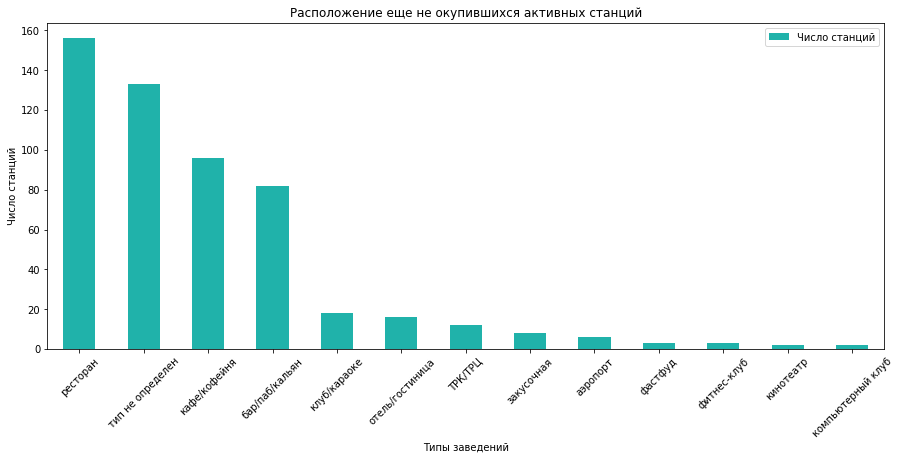

,objects_type,station_count,percentage
0,ресторан,156,29
1,тип не определен,133,25
2,кафе/кофейня,96,18
3,бар/паб/кальян,82,15
4,клуб/караоке,18,3
5,отель/гостиница,16,3
6,ТРК/ТРЦ,12,2
7,закусочная,8,1
8,аэропорт,6,1
9,фастфуд,3,1


In [120]:
# отберем активные не окупившиеся станции
connect_objects = connect.query('refunded == "not refunded"').pivot_table(index='objects_type', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
connect_objects.plot(x='objects_type', 
                          y='station_count', 
                          kind='bar', 
                          title='Расположение еще не окупившихся активных станций',
                          label='Число станций',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Типы заведений')
plt.ylabel('Число станций')
plt.xticks(rotation=45)
plt.show()


connect_objects['percentage'] = round(((connect_objects['station_count'] / connect_objects['station_count'].sum())*100), 2)
display(connect_objects)

В случае с еще не окупившимися станциями ситуация не меняется, тройка лидеров остается такой же.

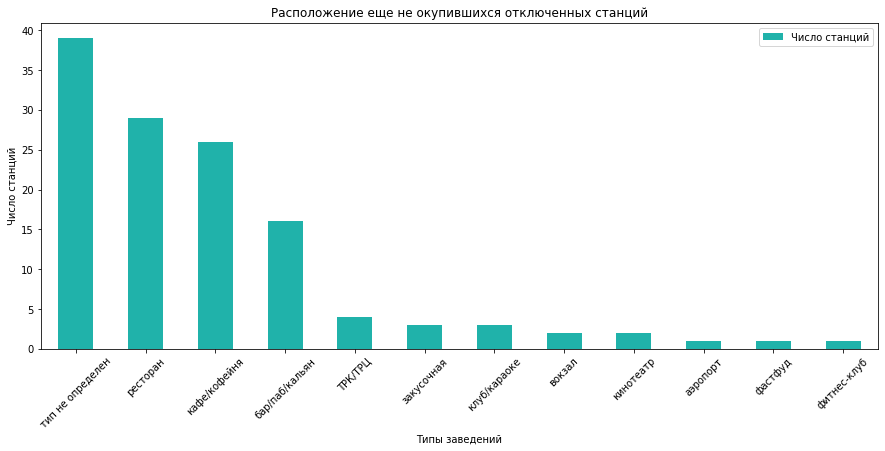

,objects_type,station_count,percentage
0,тип не определен,39,31
1,ресторан,29,23
2,кафе/кофейня,26,20
3,бар/паб/кальян,16,13
4,ТРК/ТРЦ,4,3
5,закусочная,3,2
6,клуб/караоке,3,2
7,вокзал,2,2
8,кинотеатр,2,2
9,аэропорт,1,1


In [121]:
# отберем отключенные станции
disconnect_objects = disconnect.query('refunded == "not refunded"').pivot_table(index='objects_type', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
disconnect_objects.plot(x='objects_type', 
                          y='station_count', 
                          kind='bar', 
                          title='Расположение еще не окупившихся отключенных станций',
                          label='Число станций',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Типы заведений')
plt.ylabel('Число станций')
plt.xticks(rotation=45)
plt.show()


disconnect_objects['percentage'] = round(((disconnect_objects['station_count'] / disconnect_objects['station_count'].sum())*100), 2)
display(disconnect_objects)

Чаще всего отключают станции в заведениях неустановленного типа, далее та же тройка.

Можно предположить, что среди отключенных станций лидирует неустановленный тип из-за того, что именно там зачастую оказываются несетевые небольшие заведения, которые не обладают необходимой проходимостью для того, чтобы станция начала приносить доход.

**Количество слотов у станций**

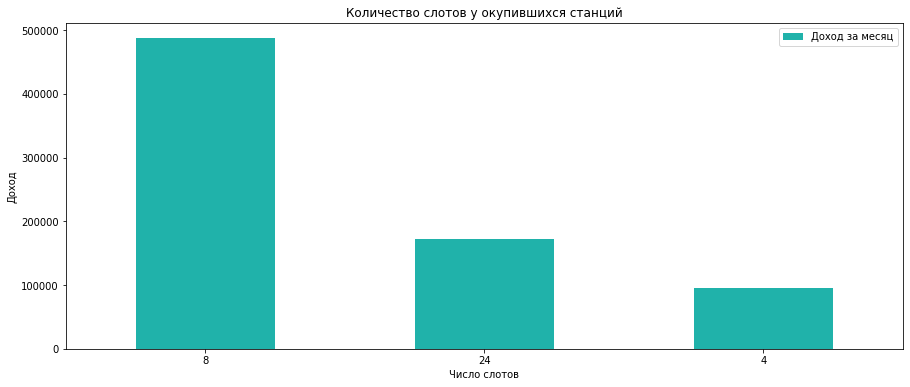

In [122]:
# отберем окупившиеся станции по числу слотов
connect_objects = connect.query('refunded == "refunded"').pivot_table(index='numberSlots', values='revenue_per_month', aggfunc='sum').sort_values(by='revenue_per_month', ascending=False).reset_index()

# построим гистограмму
connect_objects.plot(x='numberSlots', 
                          y='revenue_per_month', 
                          kind='bar', 
                          title='Количество слотов у окупившихся станций',
                          label='Доход за месяц',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Число слотов')
plt.ylabel('Доход')
plt.xticks(rotation=0)
plt.show()

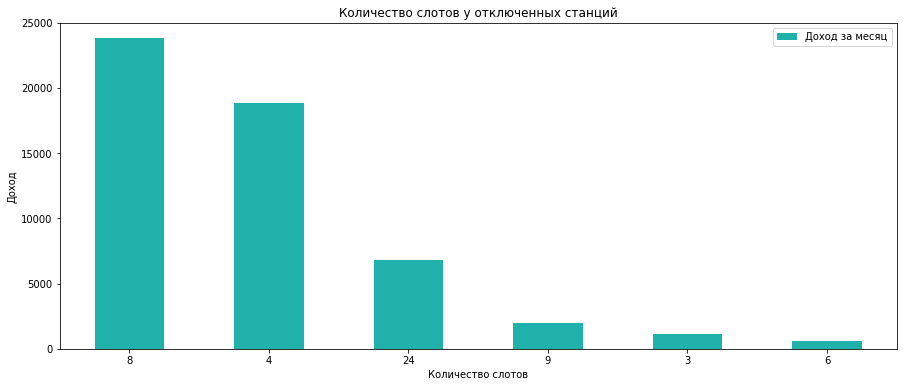

In [123]:
# отберем отключенные станции
disconnect_objects = disconnect.query('refunded == "not refunded"').pivot_table(index='numberSlots', values='revenue_per_month', aggfunc='sum').sort_values(by='revenue_per_month', ascending=False).reset_index()

# построим гистограмму
disconnect_objects.plot(x='numberSlots', 
                          y='revenue_per_month', 
                          kind='bar', 
                          title='Количество слотов у отключенных станций',
                          label='Доход за месяц',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Количество слотов')
plt.ylabel('Доход')
plt.xticks(rotation=0)
plt.show()

Большая часть окупившихся станций имеет 8 слотов, на втором месте — 24 слота, на третьем — 4 слота. Другие варианты не представлены вообще.

У отключенных станций гораздо больше разнообразия, но на первом месте мы видим также 8 слотов, на втором месте 4 слота, и дальше с большим отставанием по числу станций следует 24 слота. Присутствуют станции с 9, 3 и 6 слотами.

Посмотрим на самые удачные расположения станций на территории России по среднемесячной выручке.

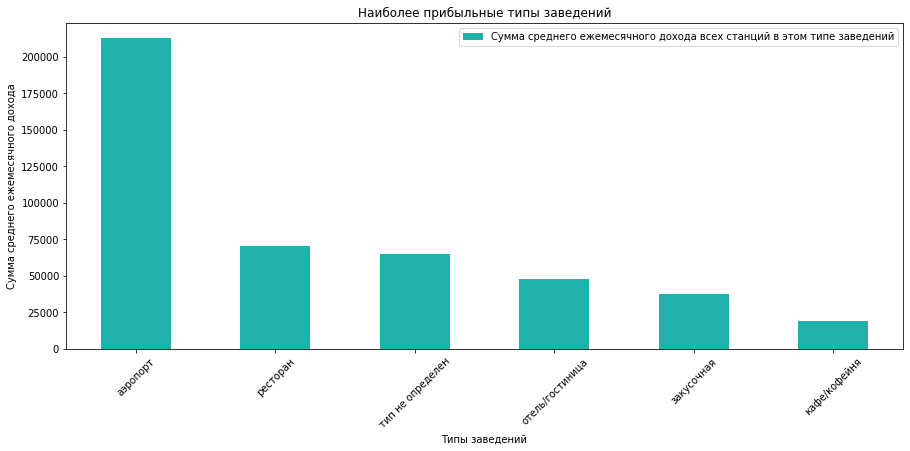

In [124]:
best_place = ru_st_avg_revenue_per_month.query('revenue_per_month >= 12000')
best_place = best_place.pivot_table(index='objects_type', values='revenue_per_month', aggfunc='sum').sort_values(by='revenue_per_month', ascending=False).reset_index()

# построим гистограмму
best_place.plot(x='objects_type', 
                          y='revenue_per_month', 
                          kind='bar', 
                          title='Наиболее прибыльные типы заведений',
                          label='Сумма среднего ежемесячного дохода всех станций в этом типе заведений',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Типы заведений')
plt.ylabel('Сумма среднего ежемесячного дохода')
plt.xticks(rotation=45)
plt.show()

Наиболее прибыльными оказались станции, размещенные в аэропортах.

Вторые по прибыльности — рестораны. На третьем месте отели и гостиницы, на четвертом — закусочные. С большим отставанием на пятом месте кафе и кофейни.

Все остальные типы заведений имеют ежемесячный средний доход меньше 12 000 руб. — эта сумма взята как минимальный ежемесячный доход, который позволит окупить маленькую (8 слотов) станцию за 3 месяца.

**4.2. Доходы компании на территории России**

А теперь поговорим о самой компании.

Для начала посчитаем, сколько денег компания получила за установку станций, чью активность мы учитывали при расчетах выше.

In [125]:
# вычтем из суммы за установку стоимость установки на предположительно тестовый период (пользование менее 14 дней)
# такой клиент был один, мы определили его ранее
installation = ru_st_avg_revenue_per_month['installation_cost'].sum() - 18000
installation

24753500

In [126]:
# рассчитаем суммы, которые поступили с указанных станций за все время
percent = ru_st_avg_revenue_per_month[['stationID', 'status', 'months', 'payment_sum', 'debt_sum', 'numberSlots', 'refunded']]
percent['revenue'] = (percent['payment_sum'] - percent['debt_sum']) / 100 * 25
percent['revenue_per_month'] = percent['revenue'] / percent['months']
percent.replace([np.inf, -np.inf], 0, inplace=True)
percent.head(3)

,stationID,status,months,payment_sum,debt_sum,numberSlots,refunded,revenue,revenue_per_month
0,FFRH082006890045,CONNECTED,26,1003800,600,8,refunded,250800,9646
1,FFRH082001660045,CONNECTED,20,1003800,600,8,refunded,250800,12540
2,FFRH082001650037,CONNECTED,20,1003800,600,8,refunded,250800,12540


In [127]:
print('Суммарный доход на территории РФ за все время составил:', percent['revenue'].sum() + installation, "руб.")
print()
print('Среднемесячный доход по процентным выплатам составил:', round(percent['revenue_per_month'].sum(), 2), 'руб.')

Суммарный доход на территории РФ за все время составил: 30940308.75 руб.

Среднемесячный доход по процентным выплатам составил: 463388.25 руб.


Так как мы не знаем издережек на ведение бизнеса, оценить мало это или много не представляется возможным.

**4.3. Доходы франчайзи на территории Беларуси**

Повторим все те же расчеты для платежей по тарифам, действующим на территории Беларуси.

In [128]:
by_segment = finished_rents.query('location == "BY"')

# сумма кредитов бел. сегмента
transactions_by_credit = transactions.query('transactionStatus == "CREDIT" and location == "BY"')
credit_by_sum = transactions_by_credit['price'].sum().astype('float')

# сумма бел. возвратов
transactions_by_refund = transactions.query('transactionStatus == "REFUND" and location == "BY"')
refund_by_sum = transactions_by_refund['price'].sum().astype('float')

# считаем сумму бел. оплат
transactions_by_payment = transactions.query('transactionStatus == "DEBIT" and location == "BY"')
payment_by_sum = transactions_by_payment['price'].sum().astype('float')

debt_by = by_segment['debt'].sum().astype('float')
amount_by = by_segment['totalAmount'].sum()

In [129]:
print('Сумма начислений по всем завершившимся арендам:', amount_by)
print('Сумма долга по всем завершившимся арендам:', debt_by)
print()
print('Сумма начисленной выручки за вычетом долга:', amount_by - debt_by)
print('Сумма фактической выручки:', payment_by_sum + credit_by_sum - refund_by_sum)

Сумма начислений по всем завершившимся арендам: 18296.5
Сумма долга по всем завершившимся арендам: 1392.5

Сумма начисленной выручки за вычетом долга: 16904.0
Сумма фактической выручки: 58472.0


Посмотрим, к каким станциям имеют отношение эти транзакции.

**4.3.1. Анализ станций по окупаемости**

In [130]:
# отберем записи
by_debit_refund_transactions = transactions.query('location == "BY"')

In [131]:
stations_debit_refund = pd.merge(by_debit_refund_transactions, finished_rents[['stationID', 'numberSlots', 'powerBankID', 'objects_type', 'rentId']], on='rentId', how='left')
stations_debit_refund = stations_debit_refund.drop_duplicates().reset_index(drop=True)

In [132]:
'Доля неопределенных станций составляет: {:.0%}'.format(stations_debit_refund['stationID'].isna().sum() / len(stations_debit_refund['stationID']))

'Доля неопределенных станций составляет: 6%'

Не все станции были определены, так как мы выбирали только закончившиеся аренды, поэтому оставим только те, которые удалось опознать.

In [133]:
stations_debit_refund = stations_debit_refund.dropna(subset=['stationID'])
stations_debit_refund.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32088 entries, 23 to 34288
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   _id                      32088 non-null  object             
 1   createdDate              32088 non-null  datetime64[ns, UTC]
 2   description              32088 non-null  object             
 3   price                    32088 non-null  float64            
 4   rentId                   32088 non-null  object             
 5   transactionStatus        32088 non-null  object             
 6   user._id                 32088 non-null  object             
 7   user.blocking            32088 non-null  object             
 8   user.createdDate         32088 non-null  datetime64[ns, UTC]
 9   user.roles               32088 non-null  object             
 10  user.telegramLoginState  32088 non-null  object             
 11  user.webUser             32

In [134]:
# добавим статус станций
stations_debit_refund = pd.merge(stations_debit_refund, stations[['stationID', 'status']], on='stationID', how='left')
stations_debit_refund = stations_debit_refund.drop_duplicates().reset_index(drop=True)
stations_debit_refund['price'] = stations_debit_refund['price'].astype('int')
stations_debit_refund.head(3)

,_id,createdDate,description,price,rentId,transactionStatus,user._id,user.blocking,user.createdDate,user.roles,user.telegramLoginState,user.webUser,location,stationID,numberSlots,powerBankID,objects_type,status
0,6221cec40115b47df33e9721,2022-03-04 08:33:08.605000+00:00,tariff period: 2,2,6221cec00115b47df33e971e,CREDIT,61f793675b54024ca04aaff8,False,2022-01-31 07:44:39.207000+00:00,"[{""role"":""USER""}]",False,True,BY,FFRH042108250217,4,5930171193856361472,фастфуд,CONNECTED
1,6221cec40115b47df33e9722,2022-03-04 08:33:08.629000+00:00,tariff period: 2 credit card: 4 6977,2,6221cec00115b47df33e971e,DEBIT,61f793675b54024ca04aaff8,False,2022-01-31 07:44:39.207000+00:00,"[{""role"":""USER""}]",False,True,BY,FFRH042108250217,4,5930171193856361472,фастфуд,CONNECTED
2,6235d6673cc6e44dc4a3bfc9,2022-03-19 13:11:03.652000+00:00,tariff period: 1,0,6235d65c3cc6e44dc4a3bfc4,CREDIT,6235d65b3cc6e44dc4a3bfc0,False,2022-03-19 13:10:51.197000+00:00,"[{""role"":""USER""}]",False,True,BY,FFRH082111850215,8,5063825300653080576,кафе/кофейня,CONNECTED


In [135]:
print('Количество записей в датасете:', len(stations_debit_refund))
print('Число возвратов:', len(stations_debit_refund.query('transactionStatus == "REFUND"')))

Количество записей в датасете: 32088
Число возвратов: 0


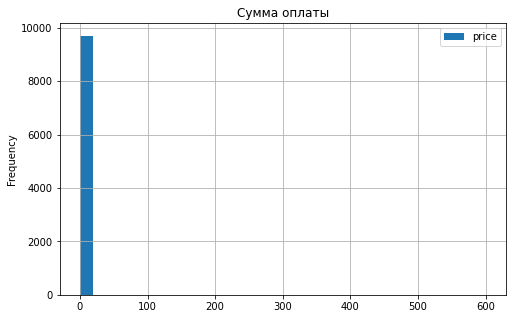

count   9690
mean       1
std        1
min        0
25%        0
50%        0
75%        2
max       12
Name: price, dtype: float64

In [136]:
# отбираем только фактические оплаты
by_stations_debit = stations_debit_refund.query('transactionStatus == "DEBIT"')
by_stations_debit.plot(y='price', kind='hist', bins=30, grid=True, title='Сумма оплаты', figsize=(8,5), range=(0,600))
plt.show()
by_stations_debit['price'].describe()

В 75% случаев оплата составила 2 бел. рубля. Максимальная сумма — 22 бел. руб.

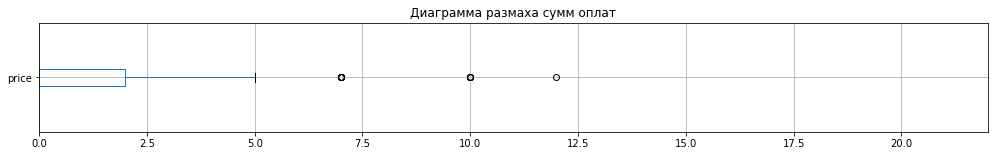

In [137]:
fig, ax = plt.subplots(figsize = (17,2))
ax = by_stations_debit[['price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха сумм оплат');
ax.set_xlim(0, 22);

Верхняя граница основной выборки находится на уровне 5 бел. руб. Выбросы малочисленны, их можно отсечь.

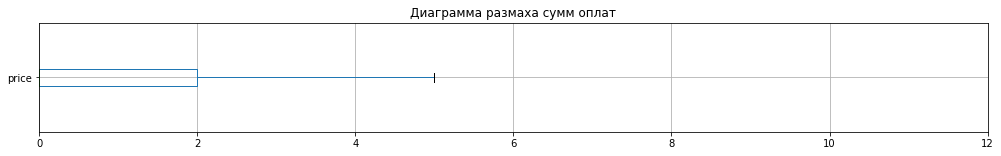

In [138]:
by_stations_debit_spread = by_stations_debit.query('price <= 5')

fig, ax = plt.subplots(figsize = (17,2))
ax = by_stations_debit_spread[['price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха сумм оплат');
ax.set_xlim(0, 12);

Теперь посмотрим, какие станции принесли больше всего денег на территории РБ по имеющимся у нас данным чуть больше чем за два с половиной года (с 27 мая 2020 года по 15 ноября 2022 года).

In [139]:
by_stations_revenue = by_stations_debit_spread.groupby('stationID')[['price']].sum().sort_values(by='price', ascending=False).reset_index()

by_stations_refund = stations_debit_refund.query('transactionStatus == "REFUND"').groupby('stationID')[['price']].sum().sort_values(by='price', ascending=False).reset_index()

by_stations_revenue = by_stations_revenue.merge(by_stations_refund, on='stationID', how='left').rename(columns={'price_x': 'payment_sum', 'price_y': 'debt_sum'})
by_stations_revenue = by_stations_revenue.drop_duplicates().reset_index(drop=True)
by_stations_revenue['debt_sum'] = by_stations_revenue['debt_sum'].fillna(0)
# сразу учтем 25%, которые отойдут компании
by_stations_revenue['revenue'] = (by_stations_revenue['payment_sum'] - by_stations_revenue['debt_sum']) - ((by_stations_revenue['payment_sum'] - by_stations_revenue['debt_sum']) / 100 * 25)
by_stations_revenue.head(3)

,stationID,payment_sum,debt_sum,revenue
0,FFRH082111470185,730,0,548
1,FFRH082111470095,730,0,548
2,FFRH082111850215,427,0,320


In [140]:
# добавим дату первой аренды для каждой станции
by_st_avg_revenue_per_month = by_stations_revenue
by_st_avg_revenue_per_month = pd.merge(by_st_avg_revenue_per_month, rents[['startDate', 'stationID']], on='stationID', how='left')
by_st_avg_revenue_per_month = by_st_avg_revenue_per_month.drop_duplicates(subset=['stationID'], keep='first').reset_index(drop=True)
by_st_avg_revenue_per_month.head(3)

,stationID,payment_sum,debt_sum,revenue,startDate
0,FFRH082111470185,730,0,548,2022-05-19 09:53:25.743000+00:00
1,FFRH082111470095,730,0,548,2022-04-01 13:54:34.232000+00:00
2,FFRH082111850215,427,0,320,2022-03-19 13:10:52.226000+00:00


In [141]:
by_st_avg_revenue_per_month['startDate'] = by_st_avg_revenue_per_month['startDate'].dt.date
by_st_avg_revenue_per_month.head(3)

,stationID,payment_sum,debt_sum,revenue,startDate
0,FFRH082111470185,730,0,548,2022-05-19
1,FFRH082111470095,730,0,548,2022-04-01
2,FFRH082111850215,427,0,320,2022-03-19


**Активные и отключенные станции**

Добавим статус станций, чтобы видеть уже не действующие.

In [142]:
by_st_avg_revenue_per_month = pd.merge(by_st_avg_revenue_per_month, stations[['status', 'stationID']], on='stationID', how='left')
by_st_avg_revenue_per_month = by_st_avg_revenue_per_month[['stationID', 'status', 'startDate', 'payment_sum', 'debt_sum', 'revenue']]
by_st_avg_revenue_per_month.head(3)

,stationID,status,startDate,payment_sum,debt_sum,revenue
0,FFRH082111470185,CONNECTED,2022-05-19,730,0,548
1,FFRH082111470095,CONNECTED,2022-04-01,730,0,548
2,FFRH082111850215,CONNECTED,2022-03-19,427,0,320


Посмотрим, как много отключенных станций и станций с неизвестным статусом в этом сегменте.

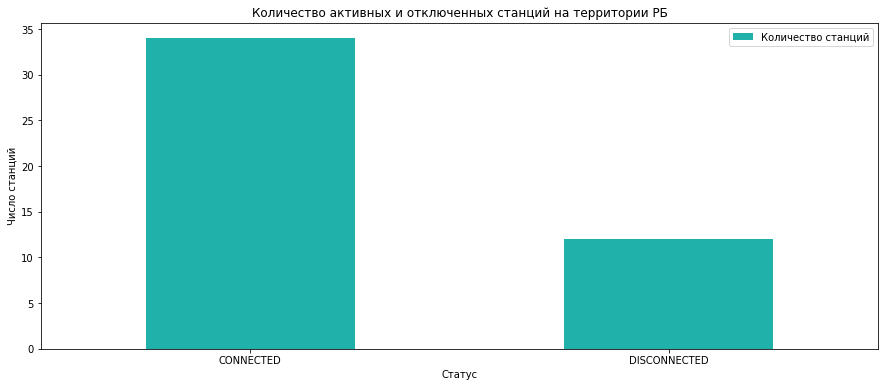

,status,station_count,percentage
0,CONNECTED,34,74
1,DISCONNECTED,12,26


Общее число станций:  46
Число станций с неизвестным статусом:  0


In [143]:
disc_by_stations = by_st_avg_revenue_per_month.pivot_table(index='status', values='stationID', aggfunc='nunique')
disc_by_stations = disc_by_stations.rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
disc_by_stations.plot(x='status', 
                          y='station_count', 
                          kind='bar', 
                          title='Количество активных и отключенных станций на территории РБ',
                          label='Количество станций',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Статус')
plt.ylabel('Число станций')
plt.xticks(rotation=0)
plt.show()


disc_by_stations['percentage'] = round(((disc_by_stations['station_count'] / disc_by_stations['station_count'].sum())*100), 2)
display(disc_by_stations)
print('Общее число станций: ', disc_by_stations['station_count'].sum())
print('Число станций с неизвестным статусом: ', by_st_avg_revenue_per_month['status'].isna().sum())

12 станций отключены по имеющимся на текущий момент данным. Для корректности расчетов используем в качестве последней дату установки статуса 'DISCONNECT'.

**Количество слотов у станций**

In [144]:
by_st_avg_revenue_per_month = pd.merge(by_st_avg_revenue_per_month, stations[['statusAt', 'stationID']], on='stationID', how='left')
by_st_avg_revenue_per_month['statusAt'] = by_st_avg_revenue_per_month['statusAt'].dt.date
by_st_avg_revenue_per_month.insert(3, 'finishDate', by_st_avg_revenue_per_month['statusAt'])
by_st_avg_revenue_per_month = by_st_avg_revenue_per_month.drop('statusAt', axis=1)
by_st_avg_revenue_per_month.head(3)

,stationID,status,startDate,finishDate,payment_sum,debt_sum,revenue
0,FFRH082111470185,CONNECTED,2022-05-19,2022-11-15,730,0,548
1,FFRH082111470095,CONNECTED,2022-04-01,2022-11-15,730,0,548
2,FFRH082111850215,CONNECTED,2022-03-19,2022-11-15,427,0,320


In [145]:
by_st_avg_revenue_per_month['finishDate'] = by_st_avg_revenue_per_month['finishDate'].fillna(by_st_avg_revenue_per_month.loc[0, "finishDate"])

by_st_avg_revenue_per_month['months'] = ((by_st_avg_revenue_per_month.finishDate - by_st_avg_revenue_per_month.startDate)/np.timedelta64(1, 'M'))
by_st_avg_revenue_per_month = by_st_avg_revenue_per_month[['stationID', 'status', 'startDate', 'finishDate', 'months', 'payment_sum', 'debt_sum', 'revenue']]

by_st_avg_revenue_per_month['revenue_per_month'] = by_st_avg_revenue_per_month['revenue'] / by_st_avg_revenue_per_month['months']
by_st_avg_revenue_per_month['status'] = by_st_avg_revenue_per_month['status'].fillna('not defined')
by_st_avg_revenue_per_month.head(3)

,stationID,status,startDate,finishDate,months,payment_sum,debt_sum,revenue,revenue_per_month
0,FFRH082111470185,CONNECTED,2022-05-19,2022-11-15,6,730,0,548,93
1,FFRH082111470095,CONNECTED,2022-04-01,2022-11-15,7,730,0,548,73
2,FFRH082111850215,CONNECTED,2022-03-19,2022-11-15,8,427,0,320,40


In [146]:
by_st_avg_revenue_per_month = pd.merge(by_st_avg_revenue_per_month, stations[['stationID', 'objects_type', 'numberSlots']], on='stationID', how='left')

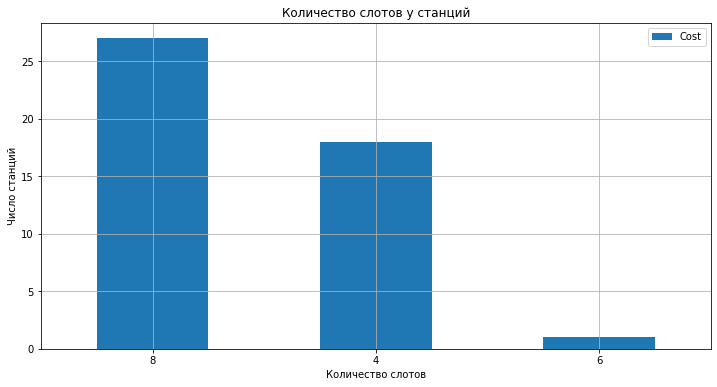

Число станций с неизвестным количеством слотов:  0


In [147]:
(
    by_st_avg_revenue_per_month.groupby('numberSlots')['stationID'].count().reset_index().sort_values('stationID', ascending=False).plot(
        x='numberSlots',
        y='stationID',
        grid=True,
        figsize=(12,6),
        style='o-',
        kind='bar',
        label='Cost',
        # color=['#355C7D', '#C06C84', '#F67280', '#F8B195'],
        # alpha=0.7
)
)

plt.xlabel("Количество слотов")
plt.ylabel('Число станций')
plt.title("Количество слотов у станций")
plt.xticks(rotation=0)
plt.show()

print('Число станций с неизвестным количеством слотов: ', by_st_avg_revenue_per_month['numberSlots'].isna().sum())

В соответствии с найденными в интернете данными, стоимость установки станции для франчайзи составляет (примерные расчеты на основании текущего курса валют):

4 слота — 690 бел. руб.

6 слотов — 996 бел. руб.

8 слотов — 1380 бел. руб.

Дополним таблицу этими данными.

In [148]:
def installationCost(value):
  if value == 4:
    return 690
  if value == 6:
    return 996
  if value == 8:
    return 1380

In [149]:
by_st_avg_revenue_per_month['installation_cost'] = by_st_avg_revenue_per_month['numberSlots'].apply(installationCost)
by_st_avg_revenue_per_month.head()

,stationID,status,startDate,finishDate,months,payment_sum,debt_sum,revenue,revenue_per_month,objects_type,numberSlots,installation_cost
0,FFRH082111470185,CONNECTED,2022-05-19,2022-11-15,6,730,0,548,93,кафе/кофейня,8,1380
1,FFRH082111470095,CONNECTED,2022-04-01,2022-11-15,7,730,0,548,73,закусочная,8,1380
2,FFRH082111850215,CONNECTED,2022-03-19,2022-11-15,8,427,0,320,40,кафе/кофейня,8,1380
3,FFRH082111650224,CONNECTED,2022-03-25,2022-11-15,8,411,0,308,40,кафе/кофейня,8,1380
4,FFRH082111070228,CONNECTED,2022-04-08,2022-11-15,7,373,0,280,39,тип не определен,8,1380


In [150]:
by_st_avg_revenue_per_month['installation_cost'] = by_st_avg_revenue_per_month['installation_cost'].fillna(0)
by_st_avg_revenue_per_month[['revenue_per_month', 'revenue', 'installation_cost', 'months']] = by_st_avg_revenue_per_month[['revenue_per_month', 'revenue', 'installation_cost', 'months']].astype('int')

In [151]:
by_st_avg_revenue_per_month['payback_month'] = round(by_st_avg_revenue_per_month['installation_cost'] / by_st_avg_revenue_per_month['revenue_per_month'])
by_st_avg_revenue_per_month.head(3)

,stationID,status,startDate,finishDate,months,payment_sum,debt_sum,revenue,revenue_per_month,objects_type,numberSlots,installation_cost,payback_month
0,FFRH082111470185,CONNECTED,2022-05-19,2022-11-15,5,730,0,547,92,кафе/кофейня,8,1380,15
1,FFRH082111470095,CONNECTED,2022-04-01,2022-11-15,7,730,0,547,73,закусочная,8,1380,19
2,FFRH082111850215,CONNECTED,2022-03-19,2022-11-15,7,427,0,320,40,кафе/кофейня,8,1380,34


In [152]:
by_st_avg_revenue_per_month['income'] = by_st_avg_revenue_per_month['revenue'] - by_st_avg_revenue_per_month['installation_cost']

In [153]:
def paybackStatus(value):
  if value >= 0:
    return 'refunded'
  if value < 0:
    return 'not refunded'

In [154]:
by_st_avg_revenue_per_month['refunded'] = by_st_avg_revenue_per_month['income'].apply(paybackStatus)
by_st_avg_revenue_per_month = by_st_avg_revenue_per_month.drop('income', axis=1)
by_st_avg_revenue_per_month.head(3)

,stationID,status,startDate,finishDate,months,payment_sum,debt_sum,revenue,revenue_per_month,objects_type,numberSlots,installation_cost,payback_month,refunded
0,FFRH082111470185,CONNECTED,2022-05-19,2022-11-15,5,730,0,547,92,кафе/кофейня,8,1380,15,not refunded
1,FFRH082111470095,CONNECTED,2022-04-01,2022-11-15,7,730,0,547,73,закусочная,8,1380,19,not refunded
2,FFRH082111850215,CONNECTED,2022-03-19,2022-11-15,7,427,0,320,40,кафе/кофейня,8,1380,34,not refunded


In [155]:
by_st_avg_revenue_per_month.replace([np.inf, -np.inf], 0, inplace=True)

In [156]:
by_st_avg_revenue_per_month['payback_month'].describe()

count     46
mean     196
std      283
min        0
25%       36
50%       81
75%      211
max     1380
Name: payback_month, dtype: float64

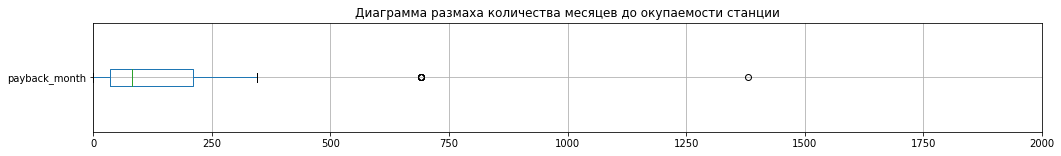

In [157]:
fig, ax = plt.subplots(figsize = (17,2))
ax = by_st_avg_revenue_per_month[['payback_month']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха количества месяцев до окупаемости станции');
ax.set_xlim(0, 2000);

Медианное значение окупаемости по всем станциям — 126 месяцев. Данные могут быть искажены наличием отключенных станций и станций без статуса. Уберем их и посмотрим на результат еще раз.

In [158]:
by_st_avg_revenue_per_month.query('status == "CONNECTED"')['payback_month'].describe()

count     34
mean     228
std      319
min        0
25%       38
50%       81
75%      230
max     1380
Name: payback_month, dtype: float64

Результат немного изменился — 115 месяцев.

Для наглядности посмотрим на станции, которые работают уже три месяца, а значит должны приближаться к точке окупаемости.

In [159]:
by_st_avg_revenue_per_month.query('status == "CONNECTED" and months == 5')

,stationID,status,startDate,finishDate,months,payment_sum,debt_sum,revenue,revenue_per_month,objects_type,numberSlots,installation_cost,payback_month,refunded
0,FFRH082111470185,CONNECTED,2022-05-19,2022-11-15,5,730,0,547,92,кафе/кофейня,8,1380,15,not refunded
7,FFRH082111200214,CONNECTED,2022-05-20,2022-11-15,5,253,0,189,32,ресторан,8,1380,43,not refunded
24,FFRH082111430200,CONNECTED,2022-06-11,2022-11-15,5,68,0,51,9,тип не определен,8,1380,153,not refunded


Станций, работающих 3 месяца не обнаружилось, но нашлась станция, работающая 4 месяца, и несколько станций, работающих 5 месяцев. Ни одна из них не окупилась.

In [160]:
connect = by_st_avg_revenue_per_month.query('status == "CONNECTED"')
connect_ref = connect.pivot_table(index='refunded', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# # построим гистограмму
# connect_ref.plot(
#     x='refunded',
#     y='station_count',
#     kind='bar',
#     title='Окупившиеся и неокупившиеся станции среди работающих',
#     label='Количество станций',
#     figsize=(15,6),
#     color='lightseagreen'
# )
# plt.xlabel('Окупаемость')
# plt.ylabel('Число станций')
# plt.xticks(rotation=0)
# plt.show()


connect_ref['percentage'] = round(((connect_ref['station_count'] / connect_ref['station_count'].sum())*100), 2)
display(connect_ref)
print('Общее число станций: ', connect_ref['station_count'].sum())

,refunded,station_count,percentage
0,not refunded,34,100


Общее число станций:  34


Активных окупившихся станций нет.

In [161]:
disconnect = by_st_avg_revenue_per_month.query('status == "DISCONNECTED"')
disc_ref = disconnect.pivot_table(index='refunded', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# # построим гистограмму
# disc_ref.plot(
#     x='refunded',
#     y='station_count',
#     kind='bar',
#     title='Окупившиеся и неокупившиеся станции среди отключенных',
#     label='Количество станций',
#     figsize=(15,6),
#     color='lightseagreen'
# )
# plt.xlabel('Окупаемость')
# plt.ylabel('Число станций')
# plt.xticks(rotation=0)
# plt.show()


disc_ref['percentage'] = round(((disc_ref['station_count'] / disc_ref['station_count'].sum())*100), 2)
display(disc_ref)
print('Общее число станций: ', disc_ref['station_count'].sum())

,refunded,station_count,percentage
0,not refunded,12,100


Общее число станций:  12


И среди отключенных не окупилась ни одна станция.

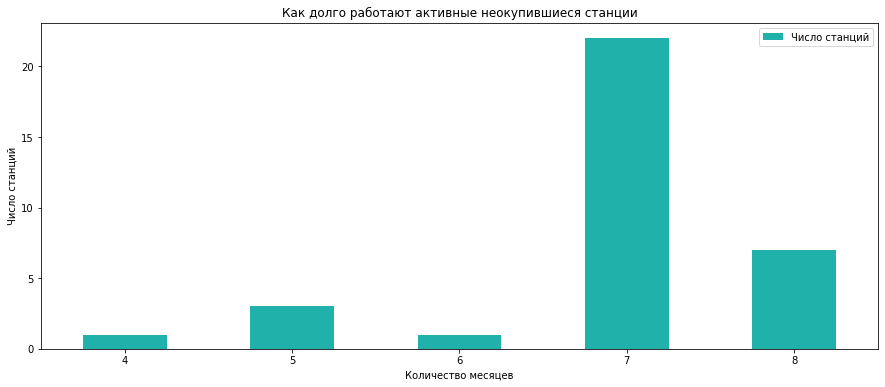

In [162]:
connect_ref = connect.query('refunded == "not refunded"').pivot_table(index='months', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='months').reset_index()

# построим гистограмму
connect_ref.plot(
    x='months',
    y='station_count',
    kind='bar',
    title='Как долго работают активные неокупившиеся станции',
    label='Число станций',
    figsize=(15,6),
    color='lightseagreen'
)
plt.xlabel('Количество месяцев')
plt.ylabel('Число станций')
plt.xticks(rotation=0)
plt.show()


Больше всего станций отрабатывают 7 месяцев, после чего происходит резкое падение — станции отключают.

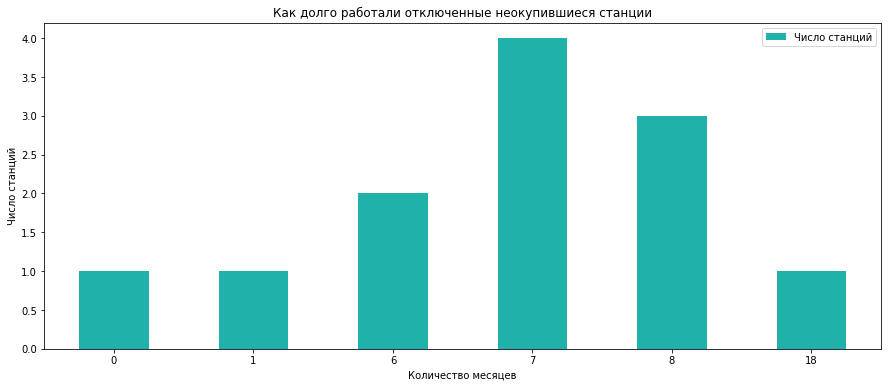

In [163]:
disc_ref = disconnect.query('refunded == "not refunded"').pivot_table(index='months', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='months').reset_index()

# построим гистограмму
disc_ref.plot(
    x='months',
    y='station_count',
    kind='bar',
    title='Как долго работали отключенные неокупившиеся станции',
    label='Число станций',
    figsize=(15,6),
    color='lightseagreen'
)
plt.xlabel('Количество месяцев')
plt.ylabel('Число станций')
plt.xticks(rotation=0)
plt.show()

Больше всего станций проработало 7 месяцев, что соответствует графику выше. Франчайзи из Беларуси ожидают, что станция начнет окупаться на 6-8 месяц своей работы, если этого не происходит, ее отключают.

In [164]:
disconnect.query('months == 0')

,stationID,status,startDate,finishDate,months,payment_sum,debt_sum,revenue,revenue_per_month,objects_type,numberSlots,installation_cost,payback_month,refunded
39,FFRT062209250001,DISCONNECTED,2022-10-18,2022-11-08,0,12,0,9,13,тип не определен,6,996,77,not refunded


Никто из клиентов не пользовался тест-драйвом.

In [165]:
payback_ref['payback_month'].describe()

count   23
mean    13
std      7
min      2
25%      8
50%     13
75%     18
max     28
Name: payback_month, dtype: float64

Медианное значение выхода на окупаемость — 13 месяцев, но для большинства станций оно составит 18 месяцев.

Посмотрим, в заведениях какого типа расположены или были расположены активные и отключенные станции

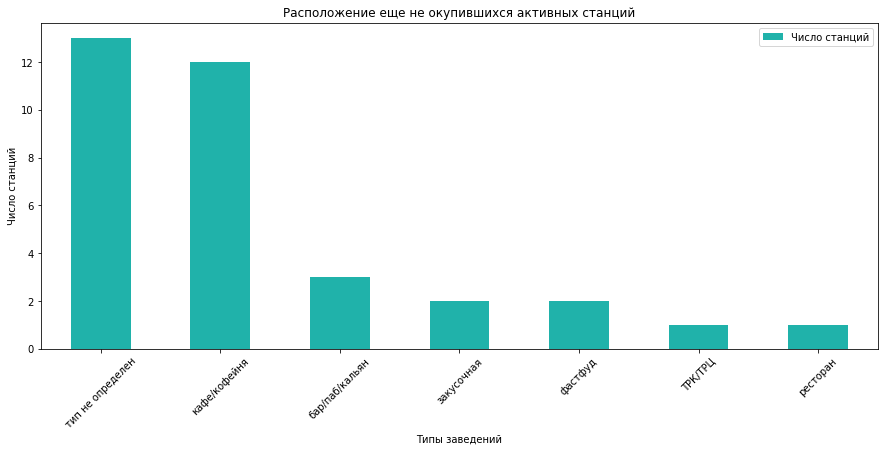

,objects_type,station_count,percentage
0,тип не определен,13,38
1,кафе/кофейня,12,35
2,бар/паб/кальян,3,9
3,закусочная,2,6
4,фастфуд,2,6
5,ТРК/ТРЦ,1,3
6,ресторан,1,3


In [166]:
# отберем активные не окупившиеся станции
connect_objects = connect.query('refunded == "not refunded"').pivot_table(index='objects_type', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
connect_objects.plot(x='objects_type', 
                          y='station_count', 
                          kind='bar', 
                          title='Расположение еще не окупившихся активных станций',
                          label='Число станций',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Типы заведений')
plt.ylabel('Число станций')
plt.xticks(rotation=45)
plt.show()


connect_objects['percentage'] = round(((connect_objects['station_count'] / connect_objects['station_count'].sum())*100), 2)
display(connect_objects)

Большинство станций было установлено в кафе и кофейнях. На территории РФ эти типы заведений на третьем месте по окупаемости и всего лишь на четвертом по суммарному ежемесячному доходу.

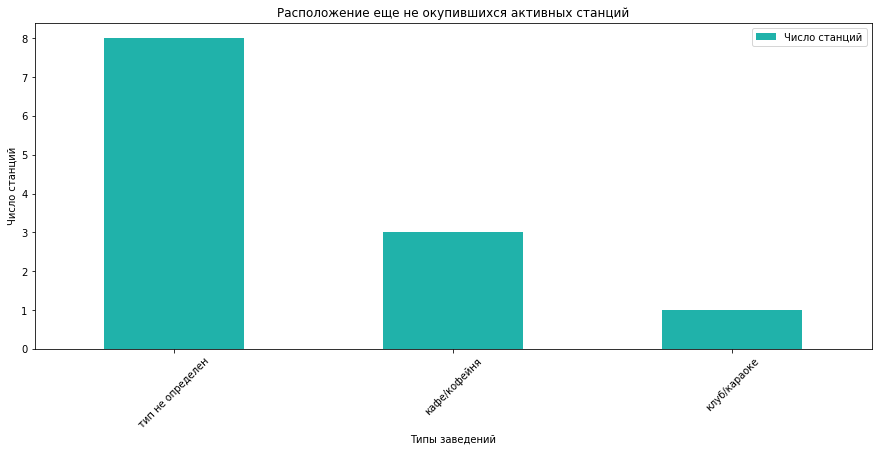

,objects_type,station_count,percentage
0,тип не определен,8,67
1,кафе/кофейня,3,25
2,клуб/караоке,1,8


Общее число станций:  12


In [167]:
# отберем отключенные станции
disconnect_objects = disconnect.query('refunded == "not refunded"').pivot_table(index='objects_type', values='stationID', aggfunc='count').rename(columns={'stationID': 'station_count'}).sort_values(by='station_count', ascending=False).reset_index()

# построим гистограмму
disconnect_objects.plot(x='objects_type', 
                          y='station_count', 
                          kind='bar', 
                          title='Расположение еще не окупившихся активных станций',
                          label='Число станций',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Типы заведений')
plt.ylabel('Число станций')
plt.xticks(rotation=45)
plt.show()


disconnect_objects['percentage'] = round(((disconnect_objects['station_count'] / disconnect_objects['station_count'].sum())*100), 2)
display(disconnect_objects)
print('Общее число станций: ', disconnect_objects['station_count'].sum())

Большинство отключенных станций были расположены в заведениях неустановленного типа, скорее всего, как и в случае РФ, это несетевые небольшие заведения.

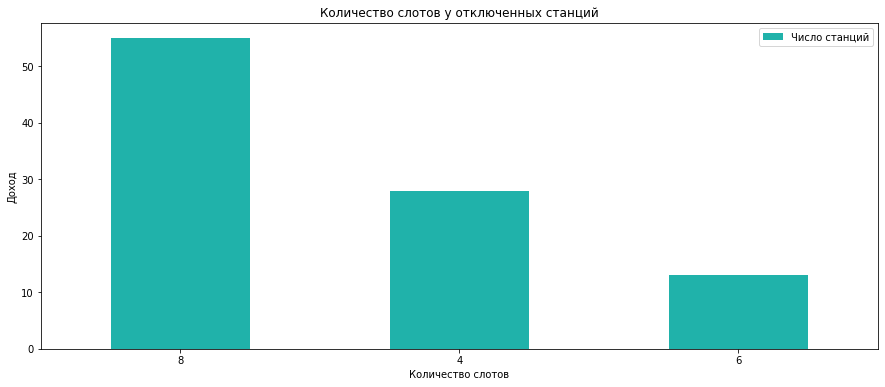

In [168]:
# отберем отключенные станции
disconnect_objects = disconnect.query('refunded == "not refunded"').pivot_table(index='numberSlots', values='revenue_per_month', aggfunc='sum').sort_values(by='revenue_per_month', ascending=False).reset_index()

# построим гистограмму
disconnect_objects.plot(x='numberSlots', 
                          y='revenue_per_month', 
                          kind='bar', 
                          title='Количество слотов у отключенных станций',
                          label='Число станций',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Количество слотов')
plt.ylabel('Доход')
plt.xticks(rotation=0)
plt.show()

График похож на общую оценку числа слотов у станций на территории РБ. Только три модели, самая популярная как по числу приобретенных, так и по числу отключенных — станция с 8 слотами.

Несмотря на в целом невеселые результаты, мы все-таки посмотрим на наиболее финансово выгодные точки размещения.

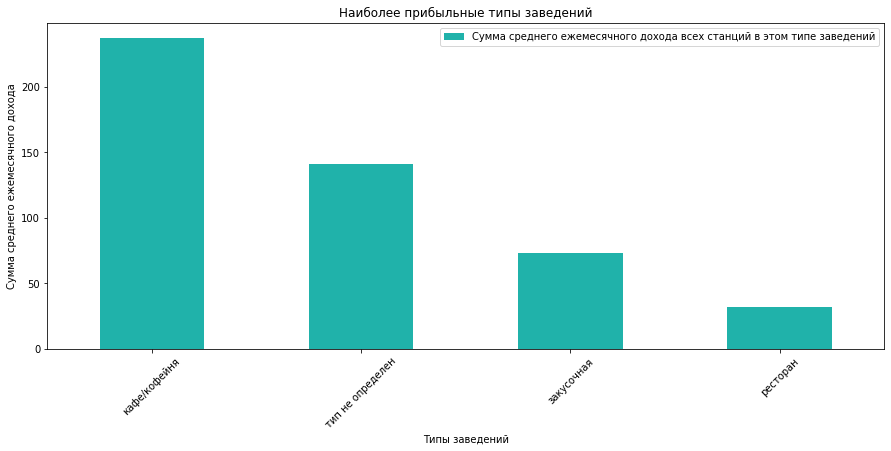

In [169]:
best_place = by_st_avg_revenue_per_month.query('revenue_per_month >= 17')
best_place = best_place.pivot_table(index='objects_type', values='revenue_per_month', aggfunc='sum').sort_values(by='revenue_per_month', ascending=False).reset_index()

# построим гистограмму
best_place.plot(x='objects_type', 
                          y='revenue_per_month', 
                          kind='bar', 
                          title='Наиболее прибыльные типы заведений',
                          label='Сумма среднего ежемесячного дохода всех станций в этом типе заведений',
                          figsize=(15,6),
                          color='lightseagreen'
)
plt.xlabel('Типы заведений')
plt.ylabel('Сумма среднего ежемесячного дохода')
plt.xticks(rotation=45)
plt.show()

Наиболее прибыльными заведениями являются кафе и кофейни, что предсказуемо: наибольшее число станций установленно именно там, и хоть какие-то деньги оттуда поступают. Но так как окупившихся станций на территории страны нет, а разнообразия в типах заведений не так много, то сложно оценить, насколько этот тип действительно потенциально прибыльный.

Франчайзи на территории РБ, к сожалению, почти ничего не получили, какие же результаты у компании?

**4.4. Доходы компании на территории Беларуси**

In [170]:
# вычтем из суммы за установку стоимость установки на предположительно тестовый период (пользование менее 14 дней)
# такой клиент был один, мы определили его ранее
installation = by_st_avg_revenue_per_month['installation_cost'].sum() - 18000
installation

32676

Рассчитаем суммы, которые поступили с указанных станций за все время.

In [171]:
percent = by_st_avg_revenue_per_month[['stationID', 'status', 'months', 'payment_sum', 'debt_sum', 'numberSlots', 'refunded']]
percent['revenue'] = (percent['payment_sum'] - percent['debt_sum']) / 100 * 25
percent['revenue_per_month'] = percent['revenue'] / percent['months']
percent.replace([np.inf, -np.inf], 0, inplace=True)
percent.head(3)

,stationID,status,months,payment_sum,debt_sum,numberSlots,refunded,revenue,revenue_per_month
0,FFRH082111470185,CONNECTED,5,730,0,8,not refunded,182,36
1,FFRH082111470095,CONNECTED,7,730,0,8,not refunded,182,26
2,FFRH082111850215,CONNECTED,7,427,0,8,not refunded,107,15


In [172]:
print('Суммарный доход на территории РБ за все время составил:', percent['revenue'].sum() + installation, "бел. руб.")
print()
print('Среднемесячный доход по процентным выплатам составил:', round(percent['revenue_per_month'].sum(), 2), 'бел. руб.')

Суммарный доход на территории РБ за все время составил: 34222.75 бел. руб.

Среднемесячный доход по процентным выплатам составил: 238.16 бел. руб.


В примерной конвертации по текущему курсу суммарный доход составил 892 529,32 руб.

Среднемесячный доход: 6211,21 руб.

**4.5. Выводы**

- Медианное значение окупаемости существующих активных станций — 39 месяцев.

- 82% станций еще не окупились.

- Среди отключенных станций есть 12%, которые тем не менее окупились. Почему это произошло, что не устроило франчайзи?

- Пик отключений происходит после 4-го месяца, когда не получается выйти на ожидаемую окупаемость. Есть станции, которые просуществовали месяц и меньше, в этом случае, скорее всего, интерес клиентов к сервису был минимальный.

- Большинству до сих пор работающих окупившихся станций потребовалось 11 месяцев для выхода на окупаемость. Медианное значение — 13 месяцев, что соответствует виденному на графике срока "жизни" уже отключенных станций: если станция получала какой-то доход (о чем свидетельствует тот факт, что ее не отключили раньше), но так и не окупилась, на 14-й месяц станция будет отключена.

- Расположены окупившиеся станции в основном в ресторанах, кафе и кофейнях, а также в барах, пабах и кальянных. 

- Наиболее прибыльными оказались станции, размещенные в аэропортах. Вторые по прибыльности — рестораны. На третьем месте отели и гостиницы, на четвертом — закусочные. С большим отставанием на пятом месте кафе и кофейни.

- Малая часть российских франчайзи получают доход с установленных станций, тогда как в Беларуси окупившихся точек нет вообще. 

**5. Общий вывод**

1. Данные.

Данные не всегда были корректно выгружены, взаимосвязь таблиц приходилось устанавливать самостоятельно и смысл части данных, возможно, был определен неверно.

- Мы не смогли воспользоваться более актуальной таблицей .json из-за потери ID пауэрбанков.

- Отображается статус и объем заряда более чем у 31% потерянных станций.

- У 42% пауэрбанков нет данных о статусе блокировки.

- Несколько пауэрбанков со статусом *blocked* находятся в аренде.

- Пауэрбанк в таблице *rent* был приписан к одному stationID, стартовая станция обозначена адресом другой станции, а последняя станция при соединении данных из таблицы *powerBankId* по ID пауэрбанка получалась третьей.

2. Целевая аудитория и пути развития.

Мы увидели, что чаще всего станции размещают у себя рестораны, кафе и различные бары, но многие из этих станций закрываются спустя несколько месяцев, так как средний срок окупаемости гораздо выше, чем предполагалось.

Это зависит и от расположения заведения, и от его популярности. Мы заметили, что отключенные станции чаще всего расположены в заведениях, чей тип не определился, и можем предположить, что это небольшие несетевые точки, чей тип не смогли определить операторы при внесении в базу данных. Размещение станций в таких местах, конечно, принесет компании доход за продажу станции, но лишит процентных выплат и может негативно повлиять на восприятие франшизы в целом.

Наиболее прибыльными оказались станции в аэропортах, ресторанах и отелях. Точек в аэропортах по сравнению с ресторанами совсем мало, но очевидно, насколько больше они приносят дохода. 

Соответственно, если мы говорим об аудитории, то это активно пользующиеся гаджетами люди, которые не имеют возможности зарядить устройство в ближайшее время, но нуждаются в нем:
- туристы или приехавшие в командировку; 
- жители города, оказавшиеся вдали от дома.

Чтобы охватить эти категории, имеет смысл разместить станции в тех аэропортах, где их еще нет.

Важно уделить внимание отелям — для людей, забыших зарядное устройство, подобные станции будут очень актуальны, да и взять с собой зарядку и не остаться посреди незнакомого города с разряженным телефоном тоже удобно. Сейчас отелей среди точек размещения станций довольно мало.

По тем же причинам интересны крупные рестораны и бары в центре города.

Эти же выводы применимы и для Беларуси.